In [1]:
import os
import sys
import random

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from kornia.losses import SSIMLoss

sys.path.append(os.path.join('..', '..', 'tta_uia_segmentation', 'src'))

from dataset.dataset_in_memory_for_ddpm import get_datasets as get_datasets_with_nn
from dataset.dataset_in_memory import get_datasets as get_datasets_without_nn  
from tta_uia_segmentation.src.models.io import load_norm_and_seg_from_configs_and_cpt
from tta_uia_segmentation.src.utils.io import load_config
from tta_uia_segmentation.src.dataset.utils import onehot_to_class, normalize_min_max
from tta_uia_segmentation.src.utils.visualization import plot_img_seg
from tta_uia_segmentation.src.utils.loss import dice_score, DescriptorRegularizationLoss 

reg_losses          = {
    'zncc': DescriptorRegularizationLoss('zncc'),
    'sift': DescriptorRegularizationLoss('sift', patch_size=256, num_ang_bins=8, num_spatial_bins=16),
    'ssim': SSIMLoss(window_size=11, reduction='mean', max_val=1.0)
    }

min_max_norm_images = [-0.8531329035758972, 0.28733062744140625]

In [2]:
def plot_augmentations(img_idx, num_examples, norm, seg, ds):
    for _ in range(num_examples):
        img, seg_gt, *_ = ds[img_idx]

        img_norm = norm(img.unsqueeze(0))
        seg_pred, _ = seg(img_norm)
        
        plot_img_seg(
            img = img.squeeze().numpy(),
            img_title='Original Augmented Image',
            seg = onehot_to_class(seg_gt.unsqueeze(0)).squeeze().numpy(),
            seg_title='Ground Truth Augmented Segmentation',
            intensity_range=(0, 1)
        )
        
        reg_sift = reg_losses['sift']
        reg_zncc = reg_losses['zncc']
        
        plot_img_seg(
            img = img_norm.squeeze().numpy(),
            img_title='NN Normalized Augmented Image\n' + \
                f'SIFT: {reg_sift(img.unsqueeze(0), img_norm).item(): 0.2e}' + \
                f', ZNCC: {reg_zncc(img.unsqueeze(0), img_norm).item(): 0.2e}' + \
                f', SSIM: {reg_losses["ssim"](img.unsqueeze(0), normalize_min_max(img_norm, *min_max_norm_images)).item(): 0.2e}',
            seg = onehot_to_class(seg_pred).squeeze(),
            seg_title=f'Predicted Augmented Segmentation\n' + \
                f'Dice Score: {dice_score(seg_gt.unsqueeze(0), seg_pred)[1].item(): 0.2%}',
            intensity_range=min_max_norm_images
        ) 
        print('\n\n' + '-'*50 + '\n\n')

In [3]:
# Load Normalizer and Segmentation model
dataset_name        = 'hcp_t1'
split               = 'val'
seg_model_dir       = '/scratch_net/biwidl319/jbermeo/data/models/brain/segmentation/hcp_t1/no_bg_supp_norm_w_3x3_conv'
device              = 'cuda' if torch.cuda.is_available() else 'cpu' 

model_params        = load_config('/scratch_net/biwidl319/jbermeo/MastersThesisUIASegmentation/config/models.yaml')
dataset_params      = load_config('/scratch_net/biwidl319/jbermeo/MastersThesisUIASegmentation/config/datasets.yaml')
dataset_params      = dataset_params[dataset_name]

# Load normalization and segmentation model
norm, seg = load_norm_and_seg_from_configs_and_cpt(
    n_classes=dataset_params['n_classes'],
    model_params_norm=model_params['normalization_2D'],
    model_params_seg=model_params['segmentation_2D'],
    cpt_fp=os.path.join(seg_model_dir, 'checkpoint_best.pth'),
    device=device    
)     
norm.eval()
seg.eval()

# Load dataset with normalized images with nn (val)
(ds_normalized,) = get_datasets_with_nn(
        splits          = [split],
        norm            = norm,   
        paths           = dataset_params['paths_processed'],
        paths_original  = dataset_params['paths_original'], 
        image_size      = (1, 256, 256),
        resolution_proc = dataset_params['resolution_proc'],
        dim_proc        = dataset_params['dim'],
        n_classes       = dataset_params['n_classes'],
        aug_params      = None,
        deformation     = None,
        load_original   = True,
        normalize       = 'none',
        bg_suppression_opts = None
    )

# Load dataset with original preprocessed images (val)
(ds, )  = get_datasets_without_nn(
        splits          = [split],
        paths           = dataset_params['paths_processed'],
        paths_original  = dataset_params['paths_original'], 
        image_size      = (1, 256, 256),
        resolution_proc = dataset_params['resolution_proc'],
        dim_proc        = dataset_params['dim'],
        n_classes       = dataset_params['n_classes'],
        aug_params      = None,
        deformation     = None,
        load_original   = True,
        bg_suppression_opts = None
    )

/scratch_net/biwidl319/jbermeo/GNN-Domain-Generalization-main/net_scratch/conda_envs/tta_uia_seg/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Determining min and max values of normalized images from a sample of 256 images
Min and max values of normalized images: -0.8810144662857056, 0.2879742980003357


# Let's check what the normalizer does for the different augmentations 

In [5]:
aug_args_default = {
    'da_ratio': 0,
    'sigma': 20,
    'alpha': 1000,
    'trans_min': -10,
    'trans_max': 10,
    'rot_min': -10,
    'rot_max': 10,
    'scale_min': 0.9,
    'scale_max': 1.1,
    'gamma_min': 0.5,
    'gamma_max': 2.0,
    'brightness_min': 0.0,
    'brightness_max': 0.1,
    'noise_mean': 0.0,
    'noise_std': 0.1
    }

### Original Image with no augmentation

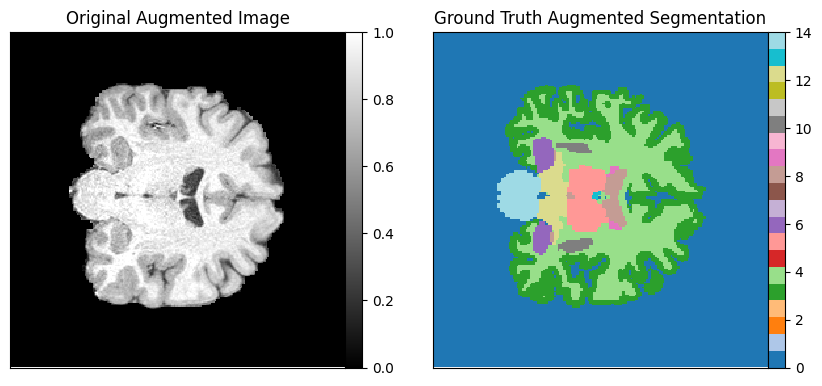

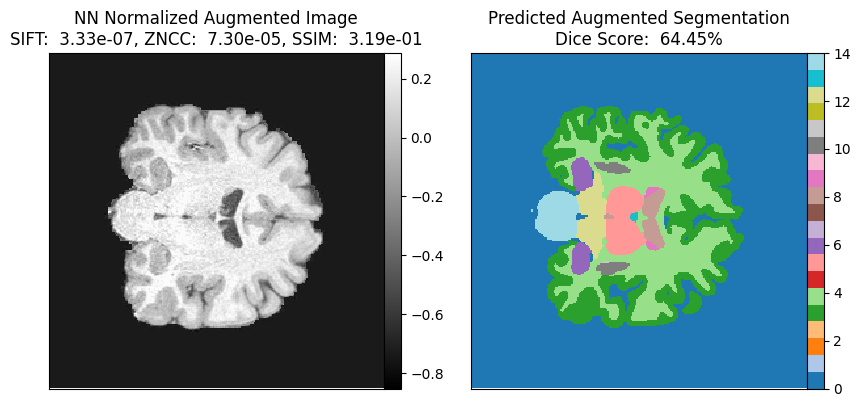



--------------------------------------------------




In [5]:
plot_augmentations(img_idx=128, num_examples=1, norm=norm, seg=seg, ds=ds)

### Elastic Deformation

In [6]:
aug_args = {
    **aug_args_default,
    'tf_probs': {'elastic_deformation': 1.0}
}
ds.augmentation = aug_args
ds.aug_params = aug_args

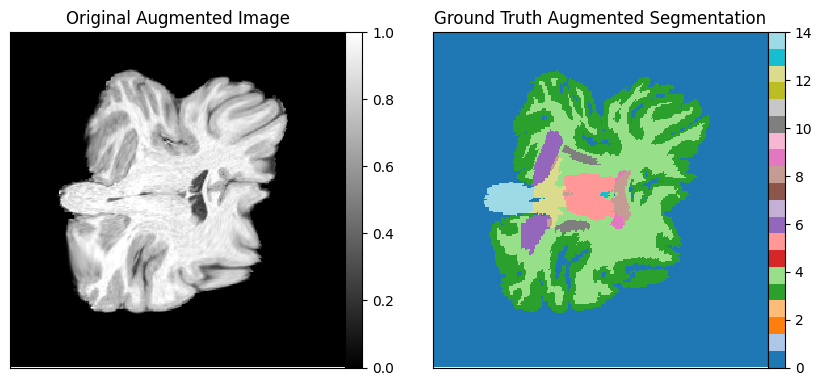

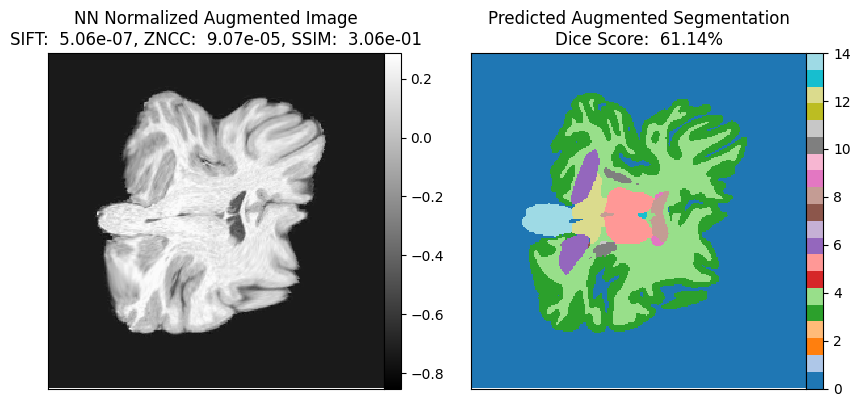



--------------------------------------------------




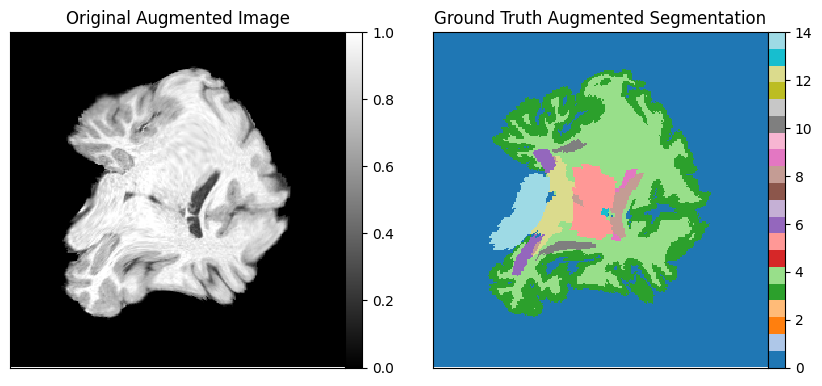

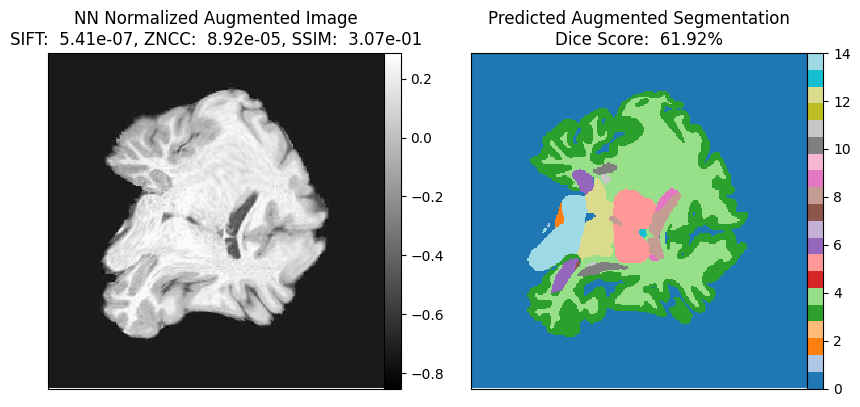



--------------------------------------------------




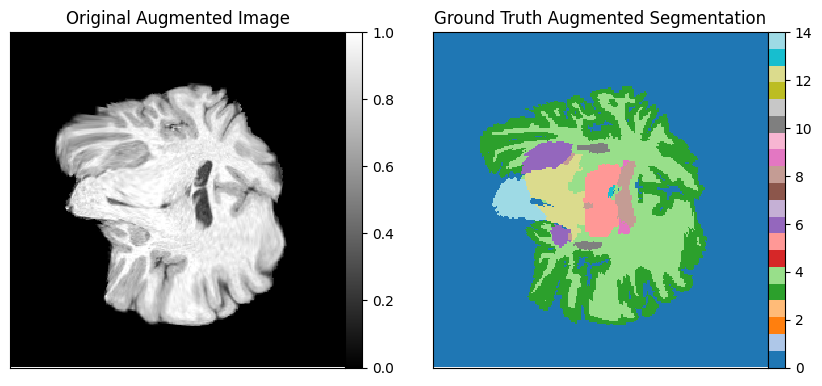

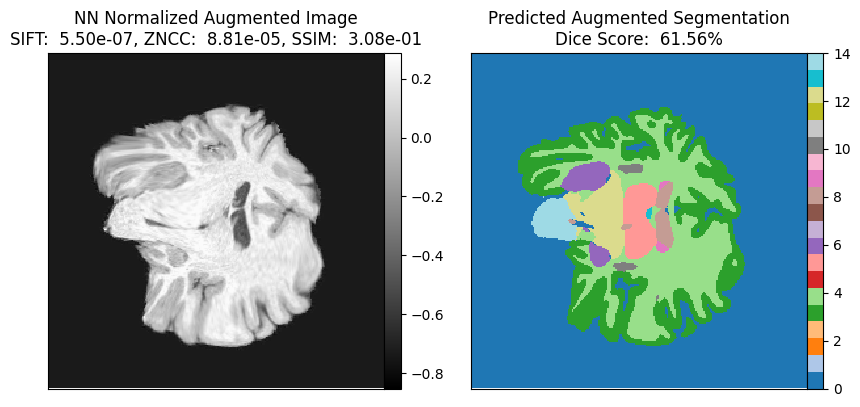



--------------------------------------------------




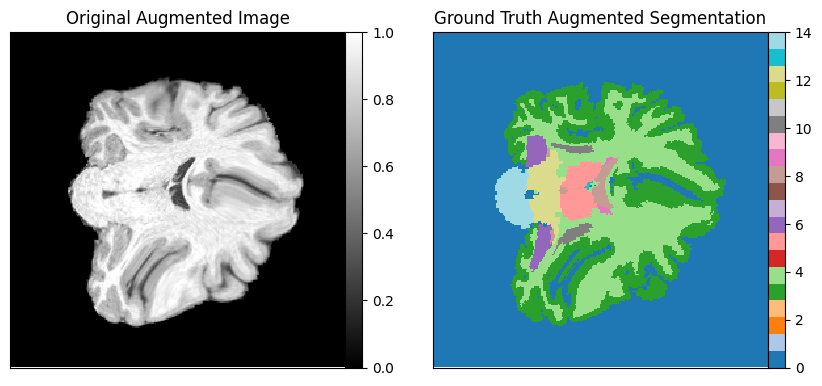

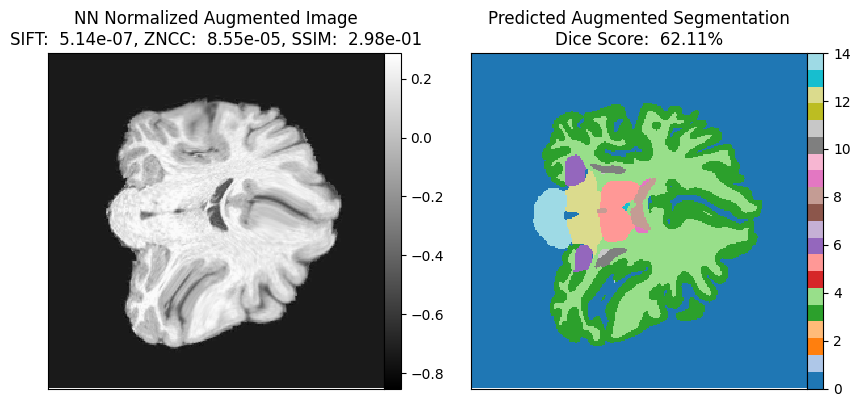



--------------------------------------------------




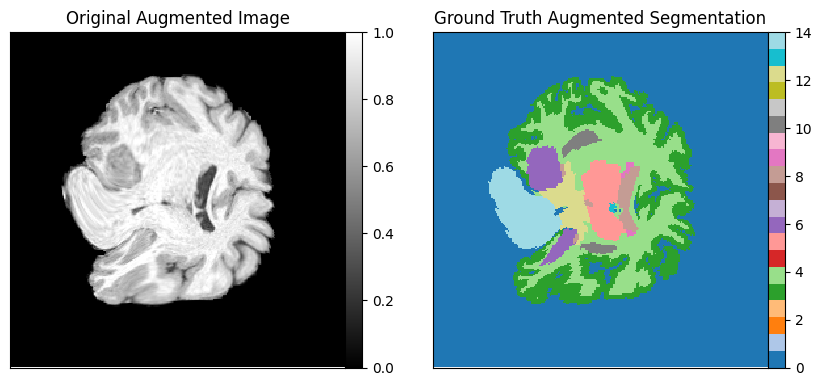

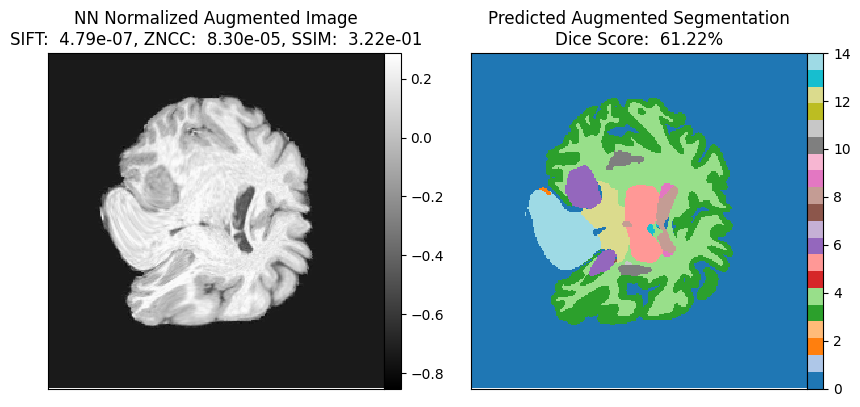



--------------------------------------------------




In [7]:
plot_augmentations(img_idx=128, num_examples=5, norm=norm, seg=seg, ds=ds)

### Scaling

In [8]:
aug_args

{'da_ratio': 0,
 'sigma': 20,
 'alpha': 1000,
 'trans_min': -10,
 'trans_max': 10,
 'rot_min': -10,
 'rot_max': 10,
 'scale_min': 0.9,
 'scale_max': 1.1,
 'gamma_min': 0.5,
 'gamma_max': 2.0,
 'brightness_min': 0.0,
 'brightness_max': 0.1,
 'noise_mean': 0.0,
 'noise_std': 0.1,
 'tf_probs': {'elastic_deformation': 1.0}}

In [9]:
aug_args = {
    **aug_args_default,
    'tf_probs': {'scaling': 1.0}
}
ds.augmentation = aug_args
ds.aug_params = aug_args

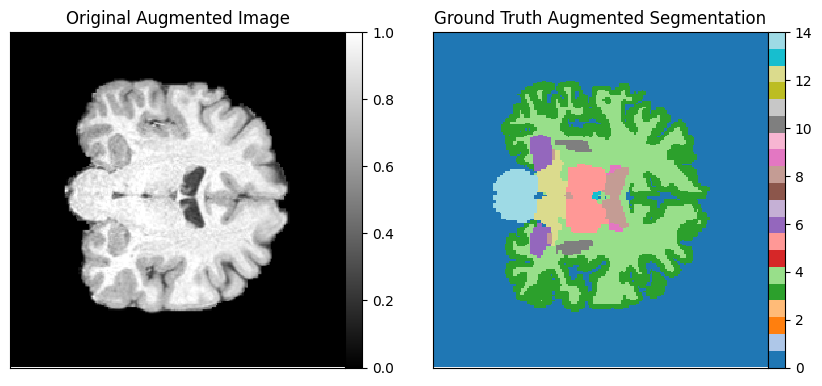

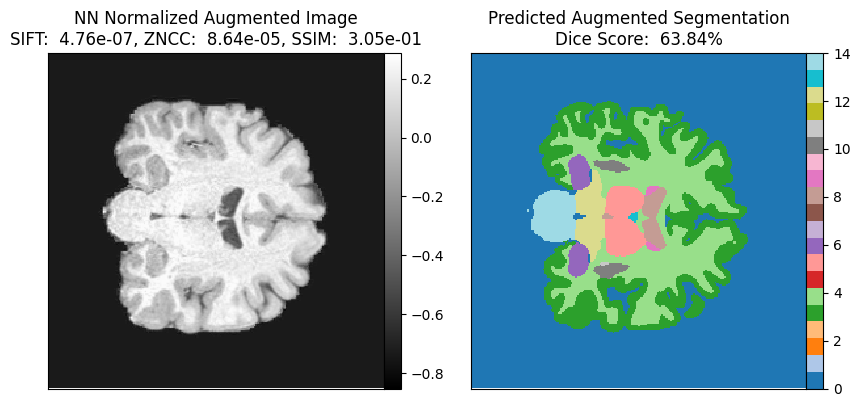



--------------------------------------------------




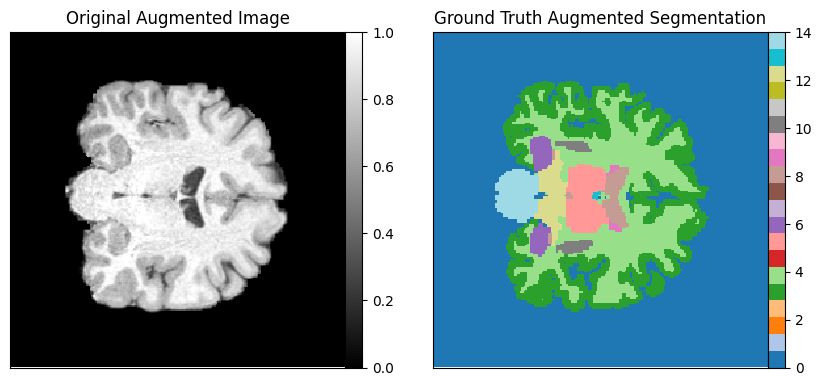

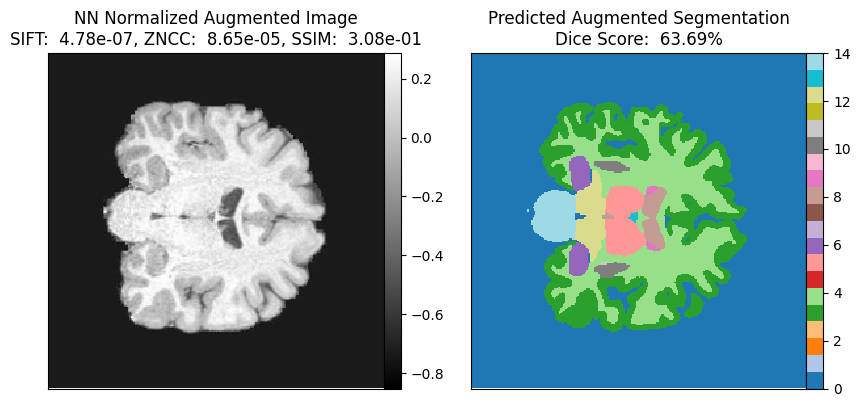



--------------------------------------------------




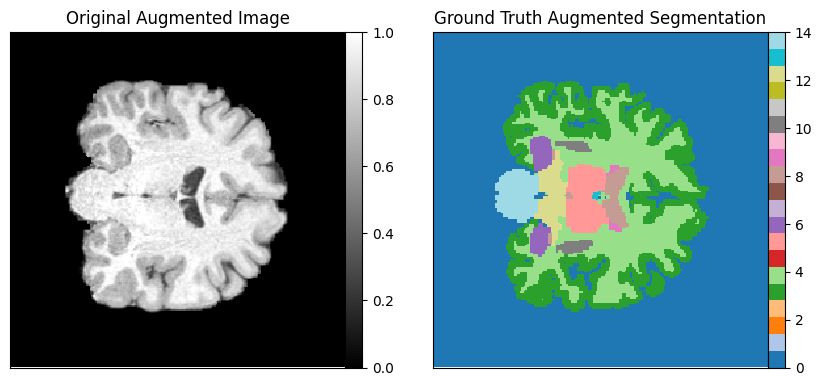

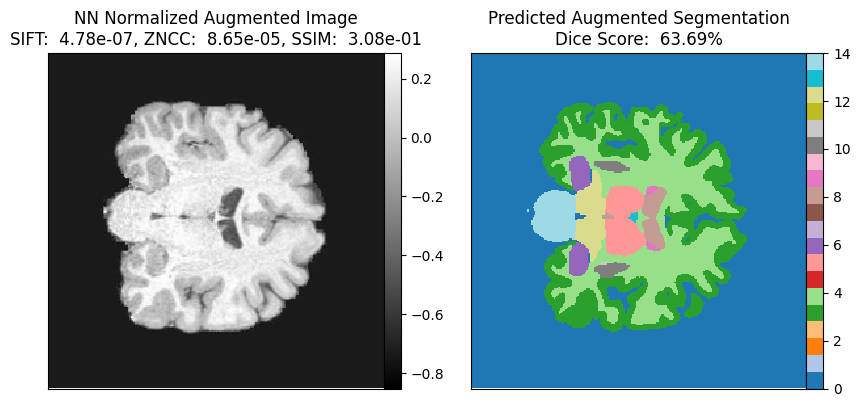



--------------------------------------------------




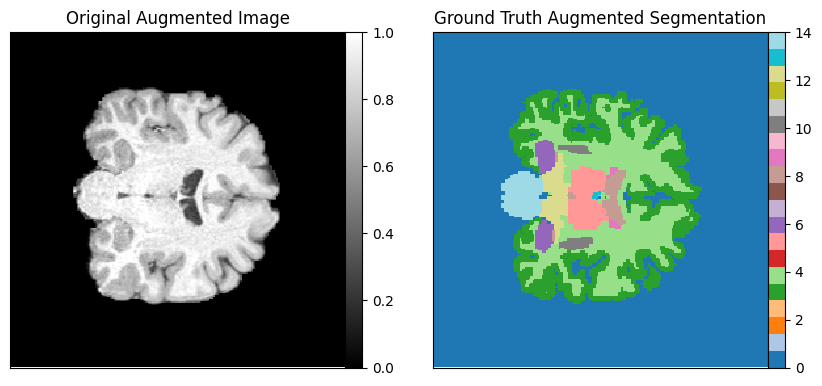

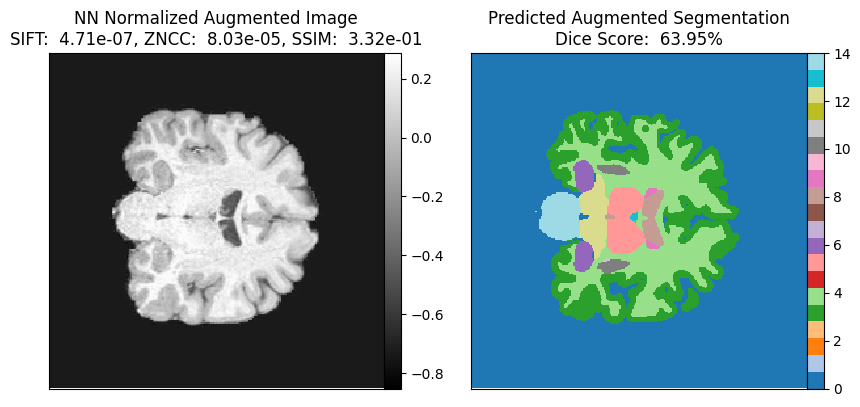



--------------------------------------------------




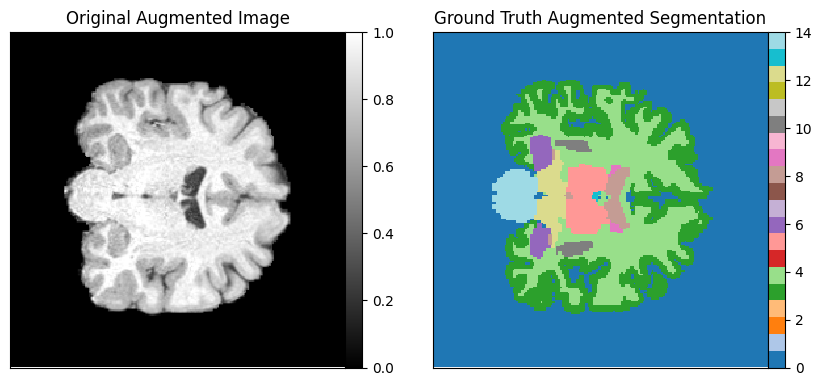

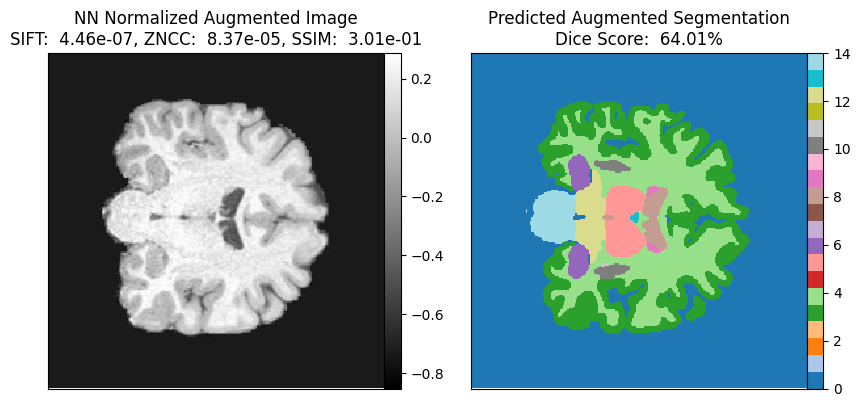



--------------------------------------------------




In [10]:
plot_augmentations(img_idx=128, num_examples=5, norm=norm, seg=seg, ds=ds)

Let's try with much stronger scalings

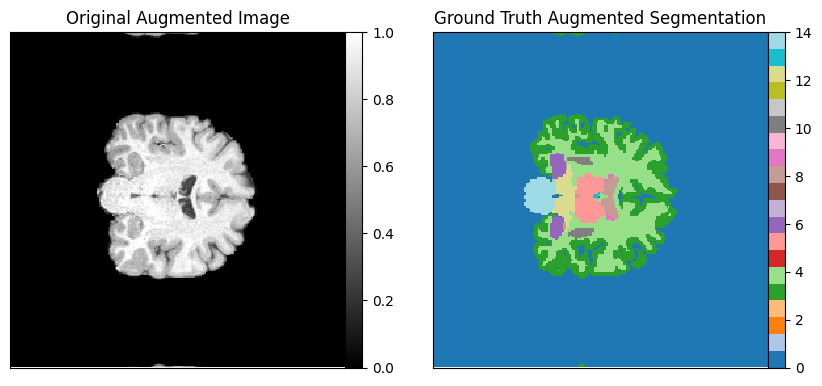

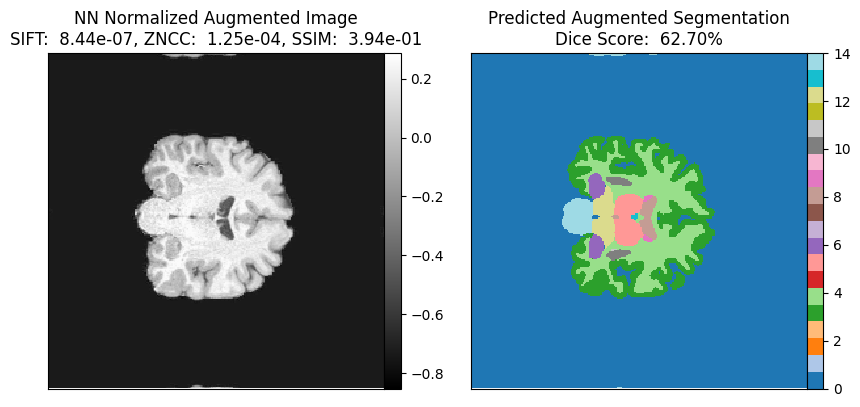



--------------------------------------------------




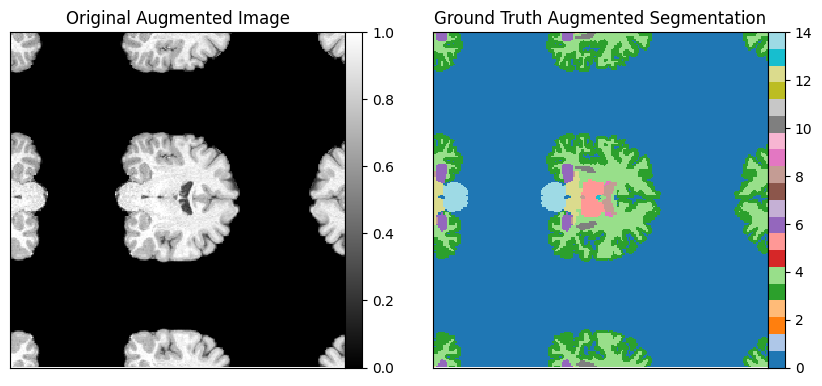

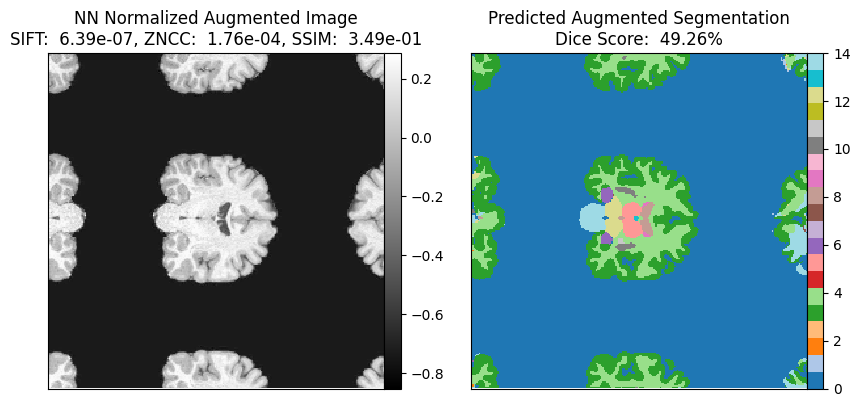



--------------------------------------------------




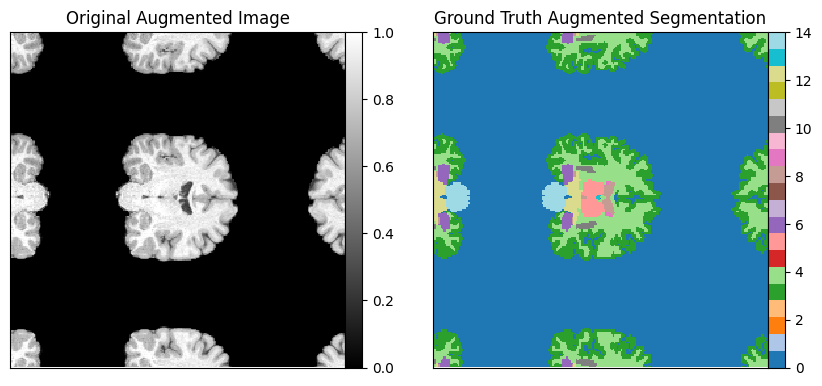

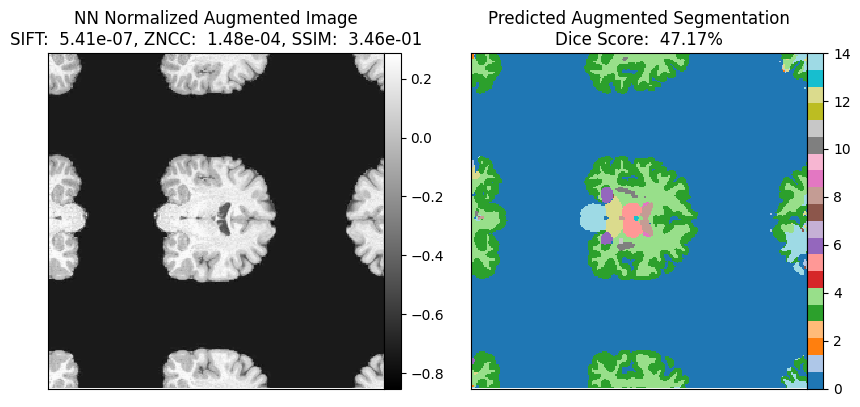



--------------------------------------------------




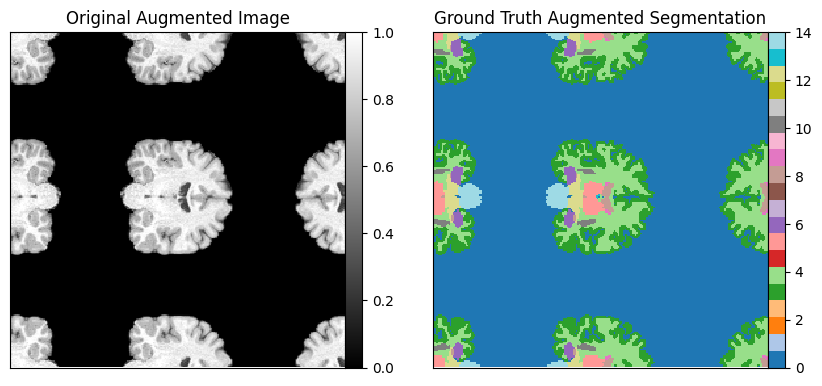

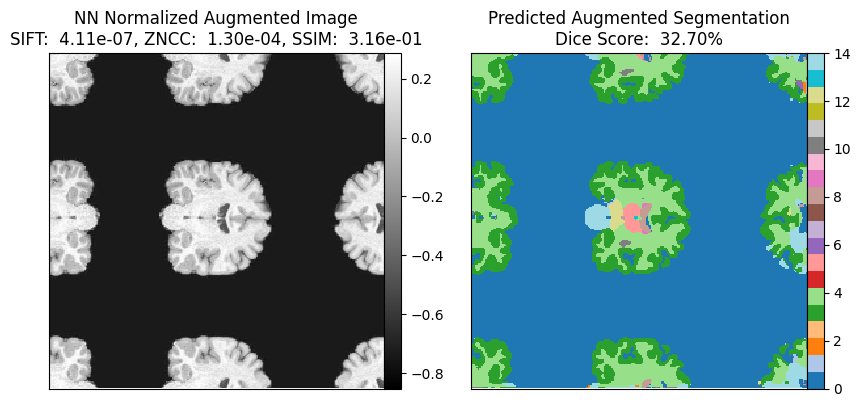



--------------------------------------------------




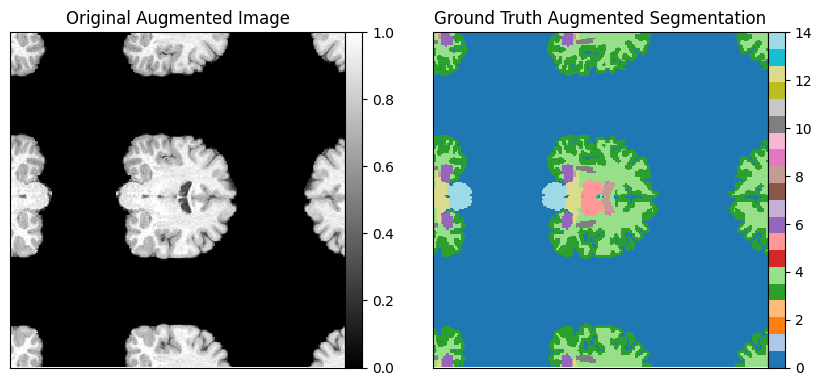

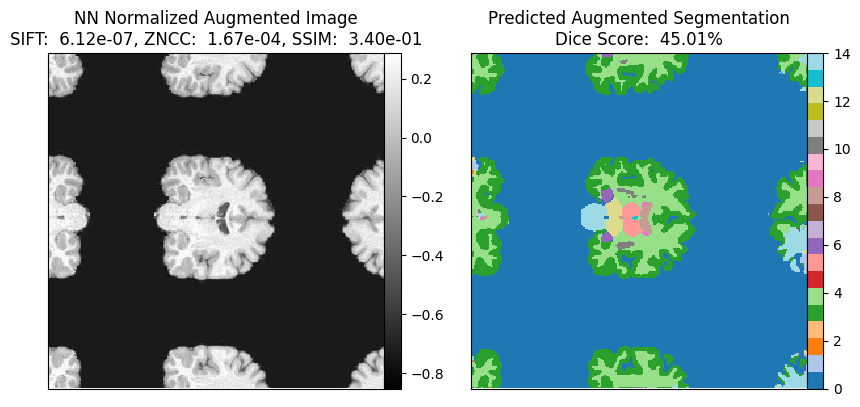



--------------------------------------------------




In [11]:
aug_args = {
    **aug_args_default,
    'tf_probs': {'scaling': 1.0}
}
aug_args['scale_min'] = 0.5
aug_args['scale_max'] = 0.75
ds.aug_params = aug_args

plot_augmentations(img_idx=128, num_examples=5, norm=norm, seg=seg, ds=ds)


### Contrast


In [6]:
aug_args_default

{'da_ratio': 0,
 'sigma': 20,
 'alpha': 1000,
 'trans_min': -10,
 'trans_max': 10,
 'rot_min': -10,
 'rot_max': 10,
 'scale_min': 0.9,
 'scale_max': 1.1,
 'gamma_min': 0.5,
 'gamma_max': 2.0,
 'brightness_min': 0.0,
 'brightness_max': 0.1,
 'noise_mean': 0.0,
 'noise_std': 0.1}

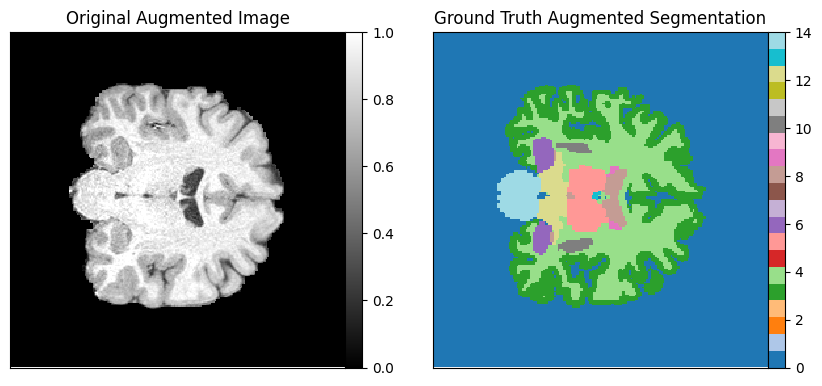

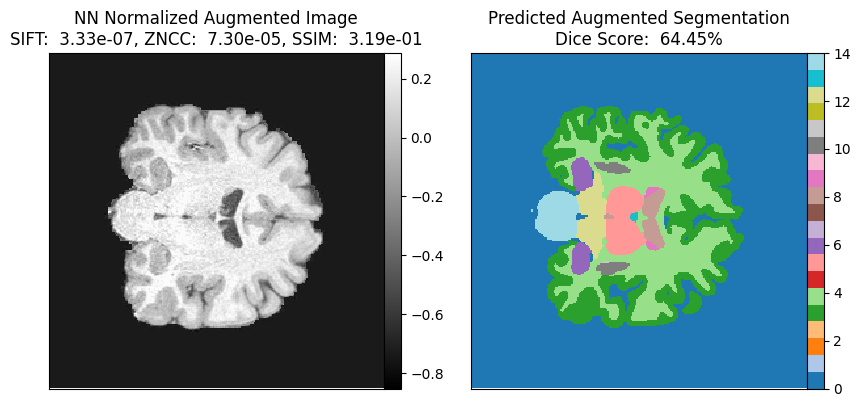



--------------------------------------------------




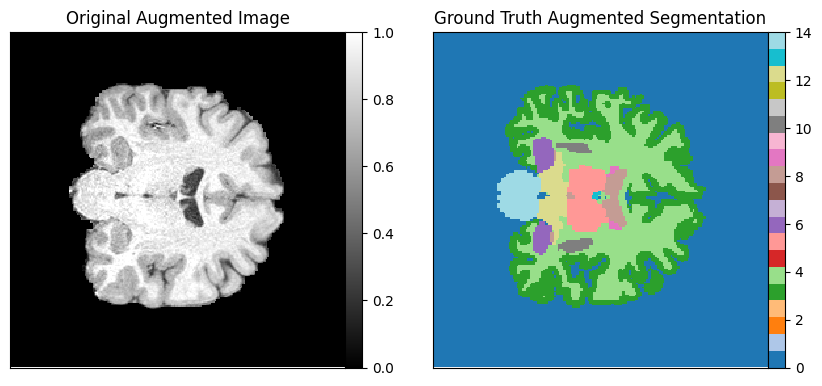

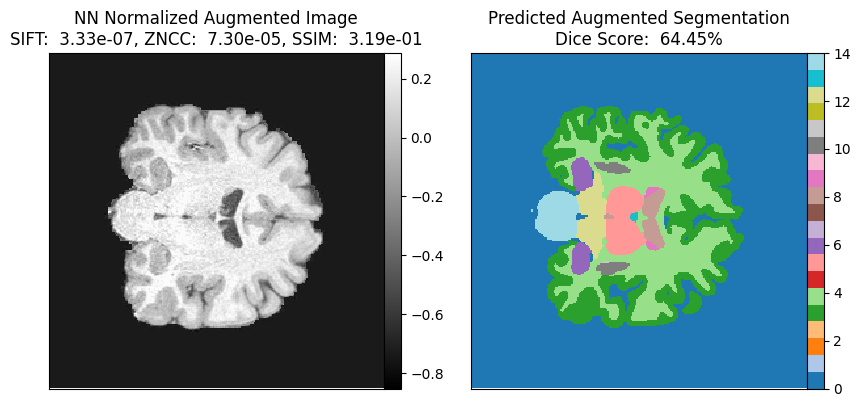



--------------------------------------------------




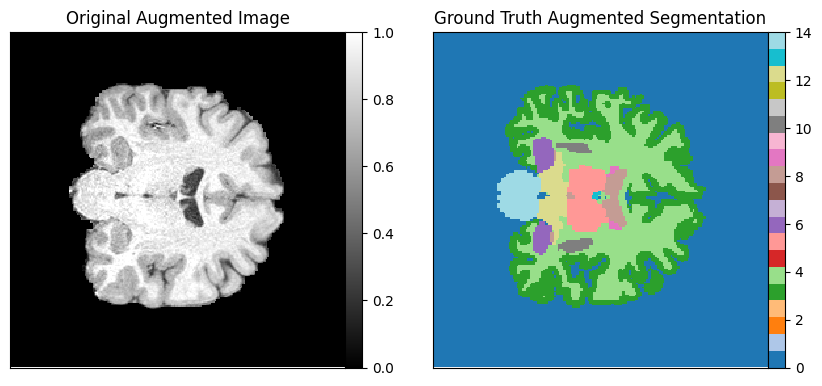

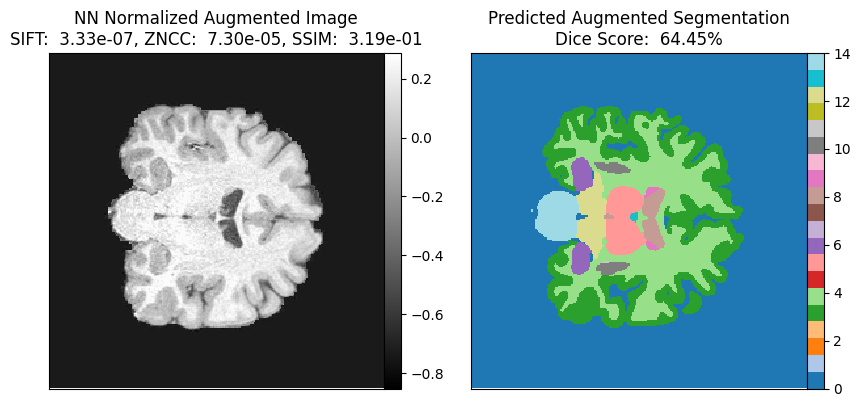



--------------------------------------------------




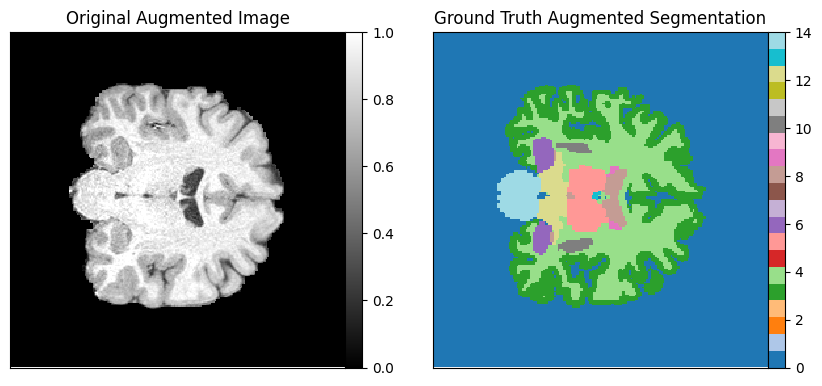

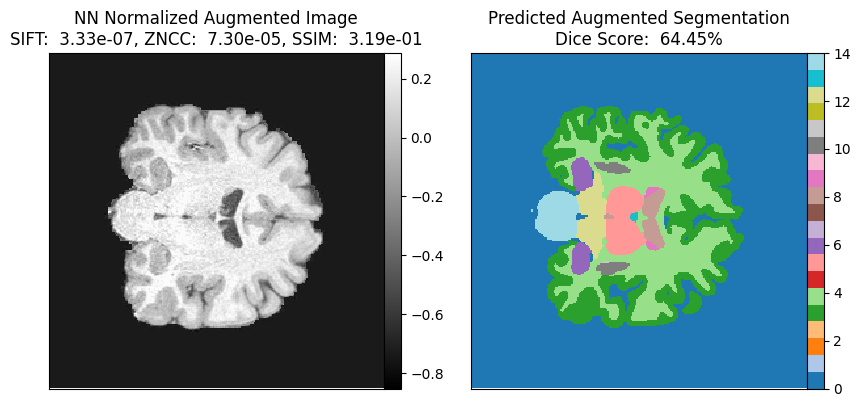



--------------------------------------------------




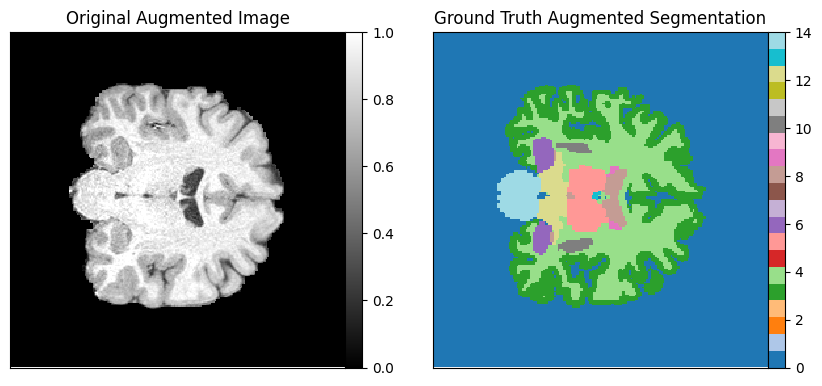

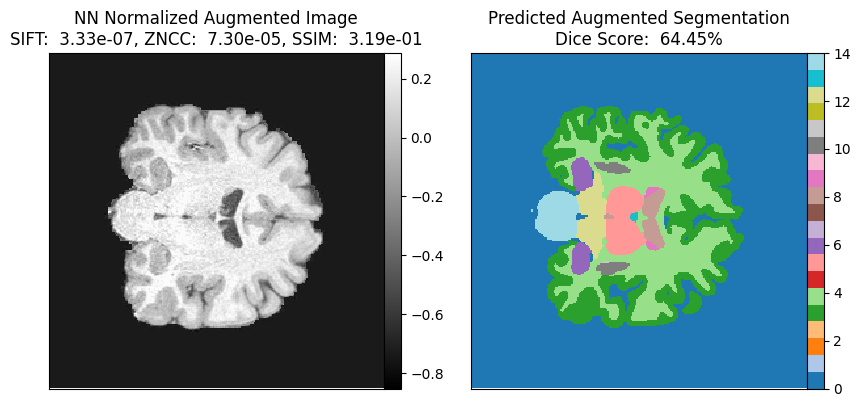



--------------------------------------------------




In [8]:
aug_args = {
    **aug_args_default,
    'tf_probs': {'contrast': 1.0}
}
aug_args['gamma_min'] = 5/6
aug_args['gamma_max'] = 5/6#1.2
ds.aug_params = aug_args

plot_augmentations(img_idx=128, num_examples=5, norm=norm, seg=seg, ds=ds)

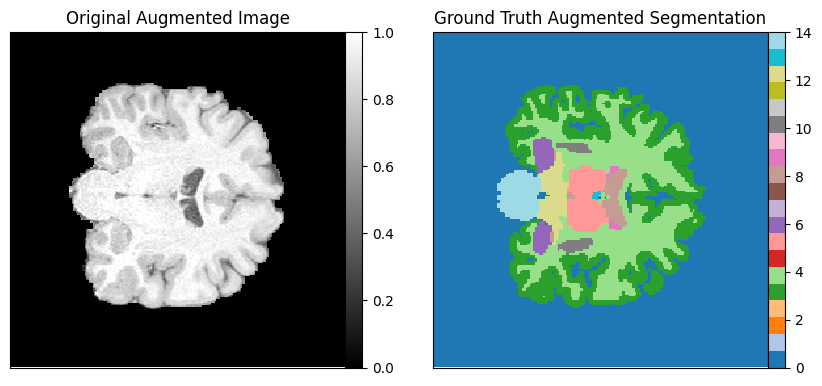

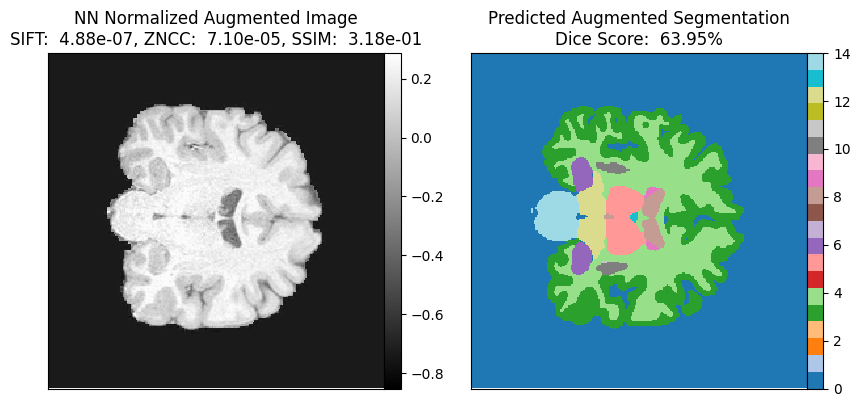



--------------------------------------------------




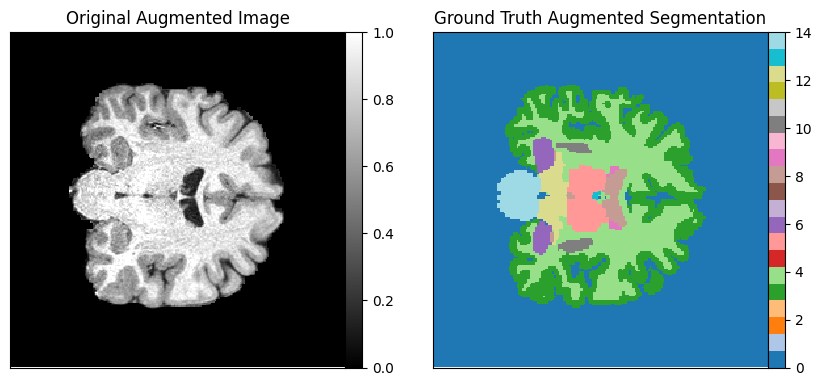

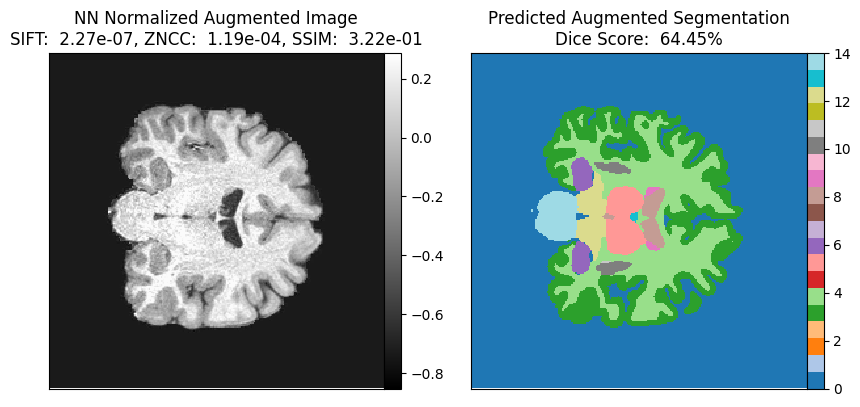



--------------------------------------------------




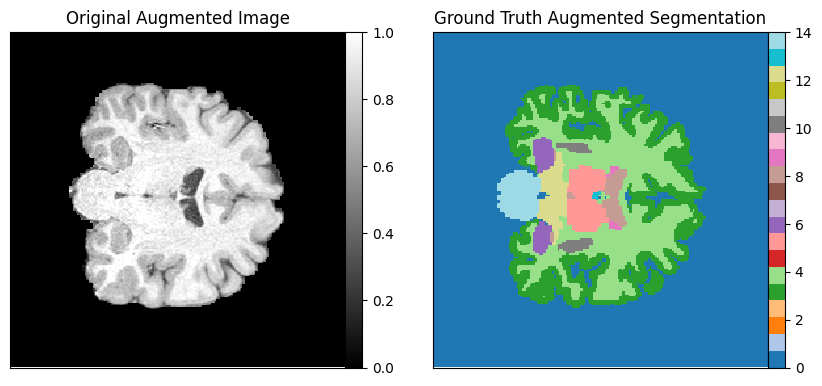

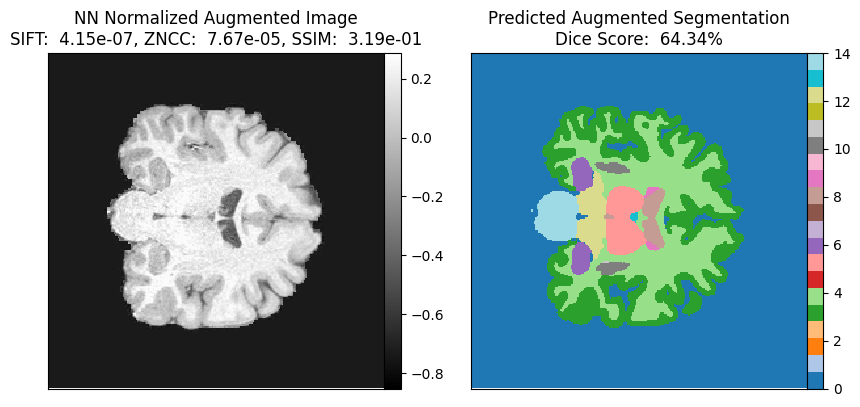



--------------------------------------------------




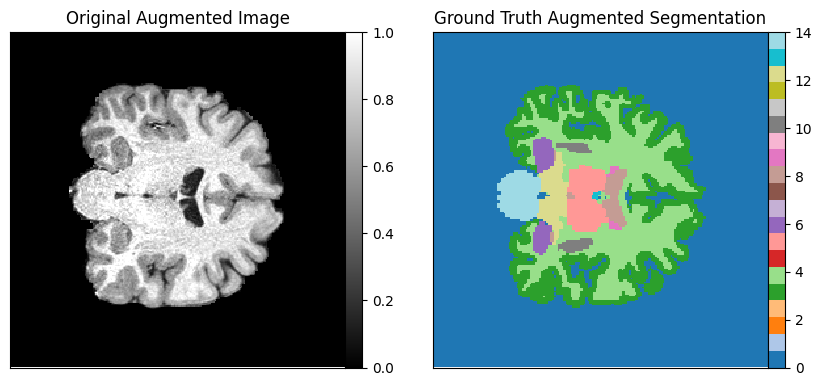

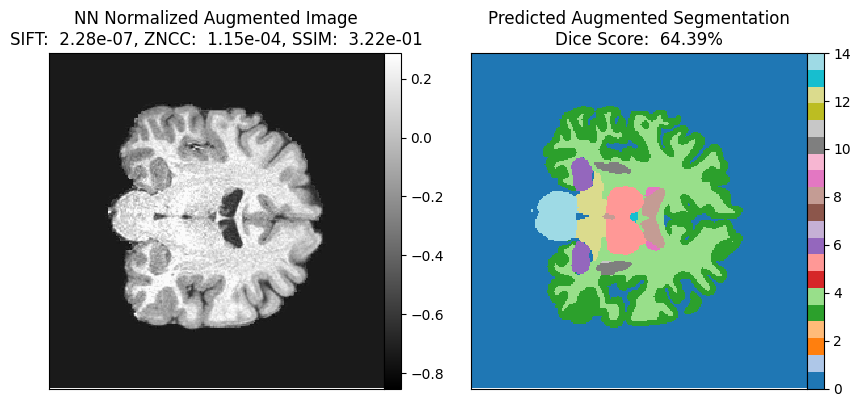



--------------------------------------------------




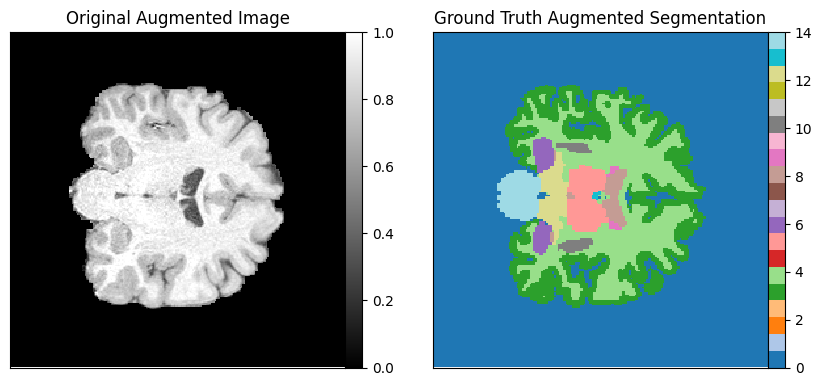

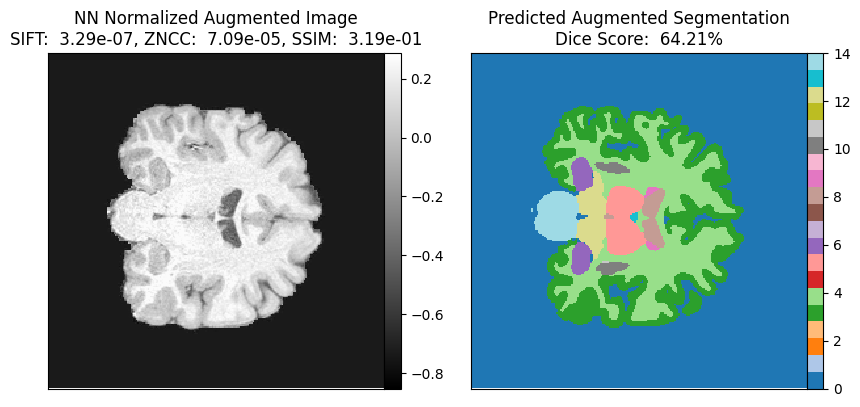



--------------------------------------------------




In [13]:
aug_args = {
    **aug_args_default,
    'tf_probs': {'contrast': 1.0}
}
#aug_args['gamma_min'] = 0.5
#aug_args['gamma_max'] = 0.75
ds.aug_params = aug_args

plot_augmentations(img_idx=128, num_examples=5, norm=norm, seg=seg, ds=ds)

More aggressive contrast augmentation

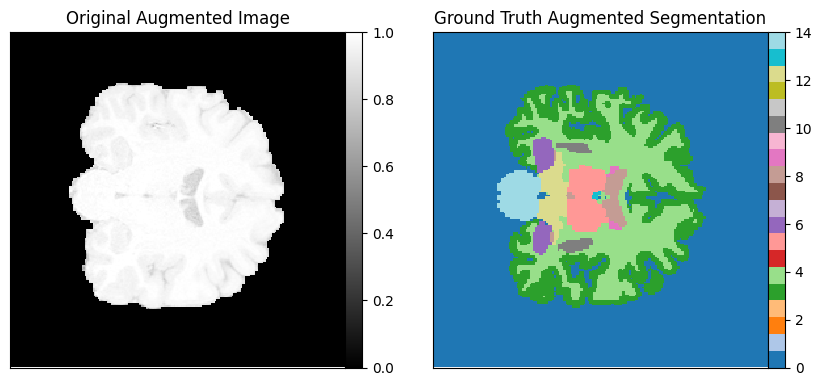

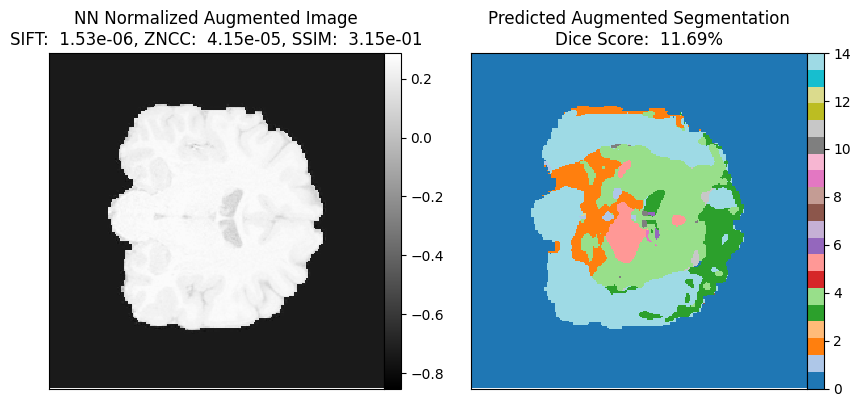



--------------------------------------------------




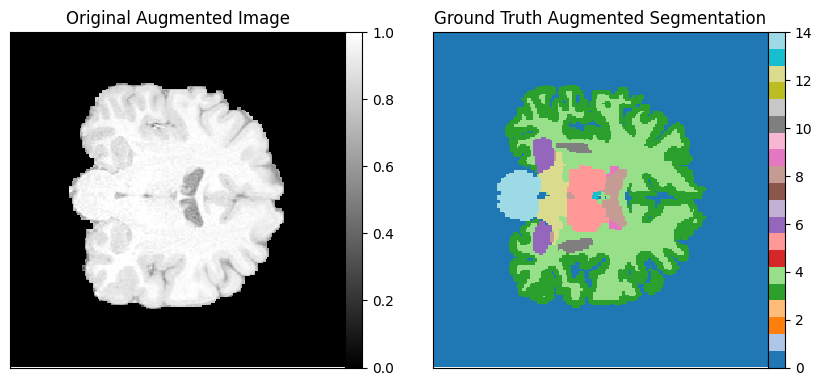

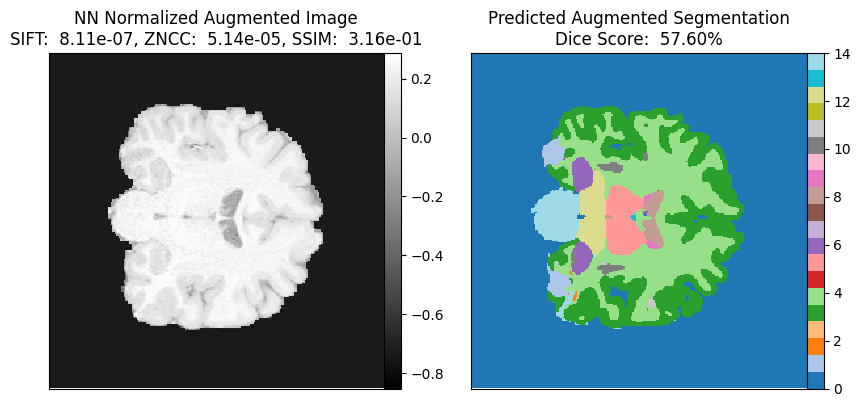



--------------------------------------------------




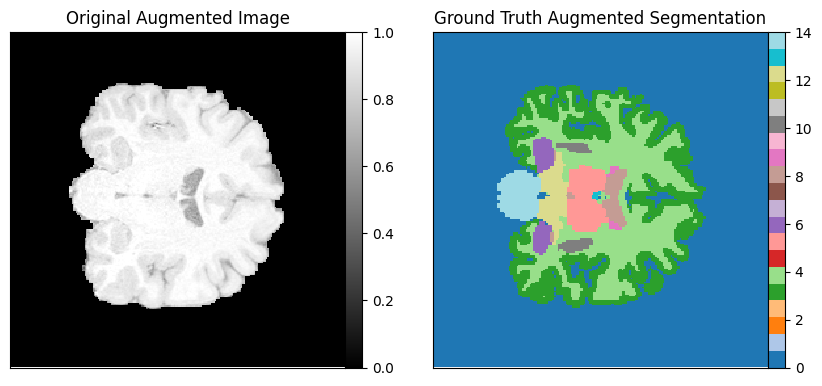

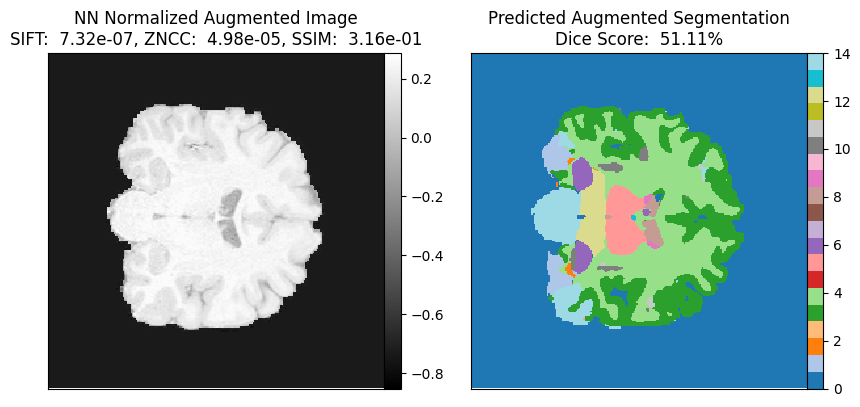



--------------------------------------------------




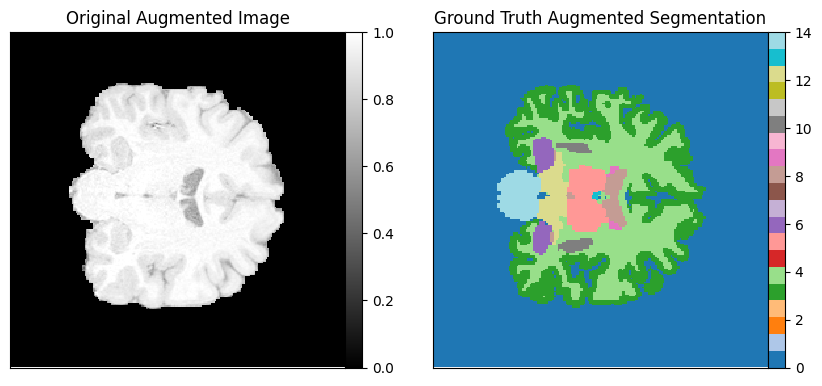

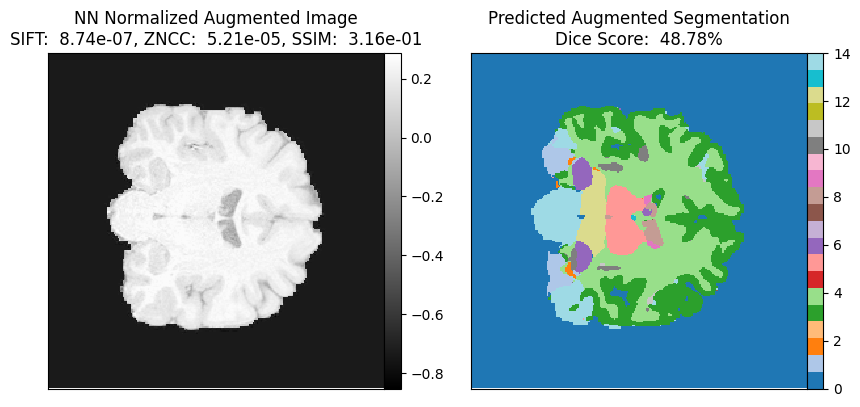



--------------------------------------------------




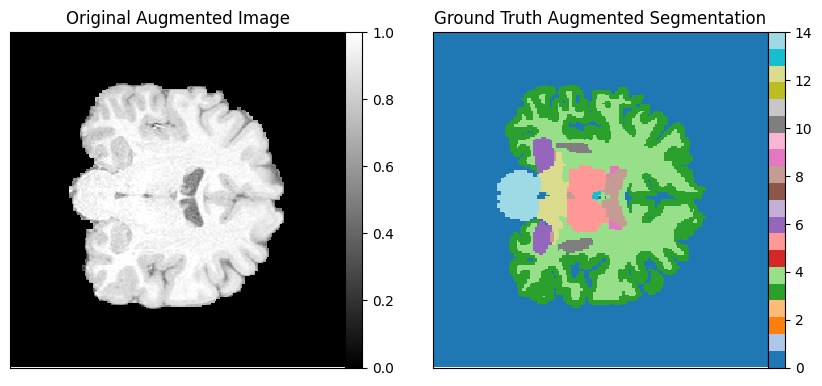

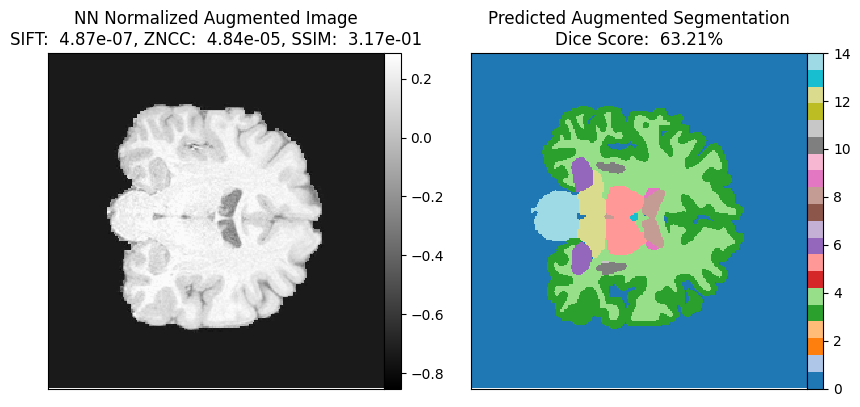



--------------------------------------------------




In [14]:
aug_args = {
    **aug_args_default,
    'tf_probs': {'contrast': 1.0}
}
aug_args['gamma_min'] = 0.1
aug_args['gamma_max'] = 0.5
ds.aug_params = aug_args

plot_augmentations(img_idx=128, num_examples=5, norm=norm, seg=seg, ds=ds)


### Brightness


In [15]:
aug_args_default

{'da_ratio': 0,
 'sigma': 20,
 'alpha': 1000,
 'trans_min': -10,
 'trans_max': 10,
 'rot_min': -10,
 'rot_max': 10,
 'scale_min': 0.9,
 'scale_max': 1.1,
 'gamma_min': 0.5,
 'gamma_max': 2.0,
 'brightness_min': 0.0,
 'brightness_max': 0.1,
 'noise_mean': 0.0,
 'noise_std': 0.1}

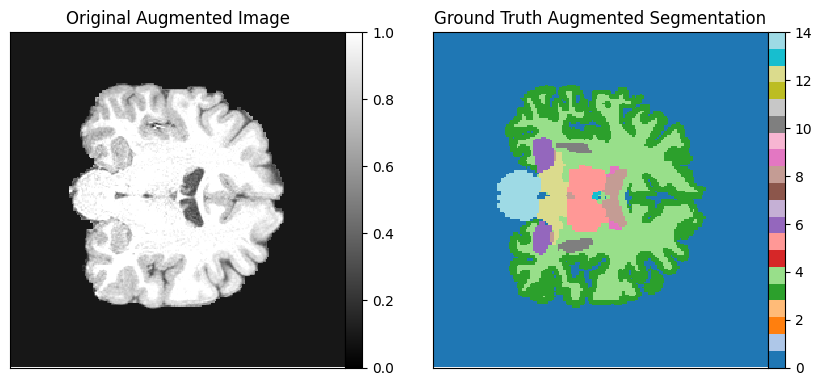

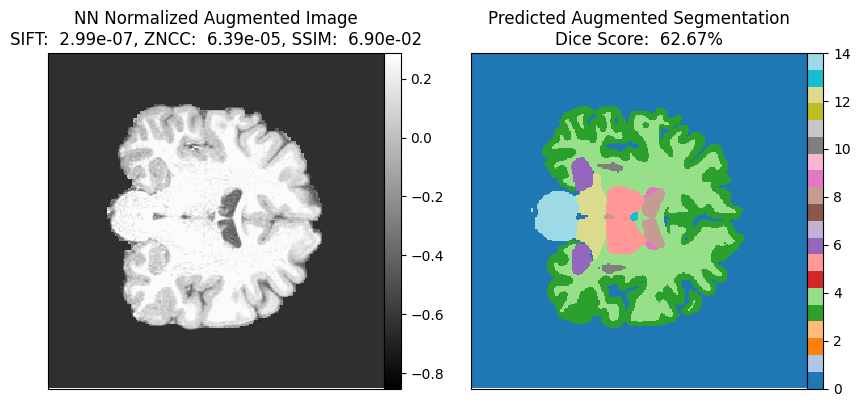



--------------------------------------------------




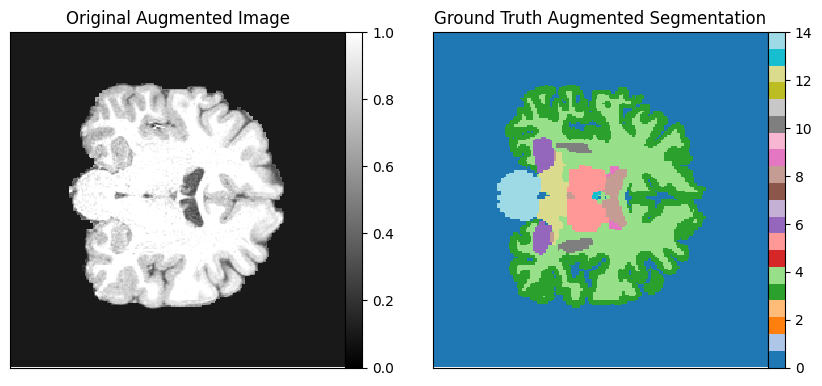

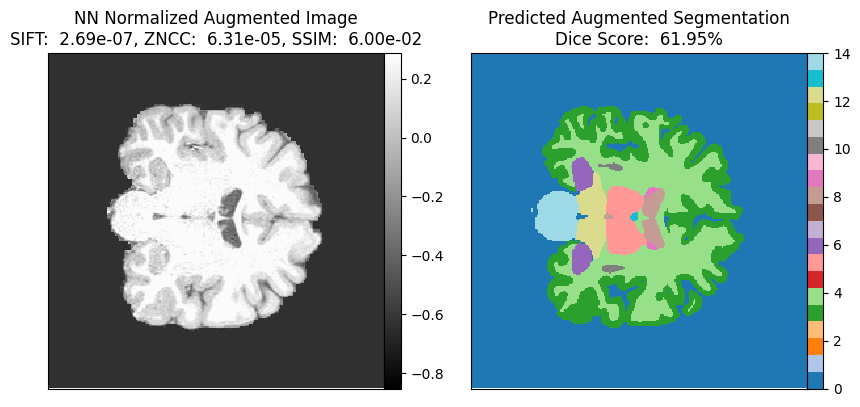



--------------------------------------------------




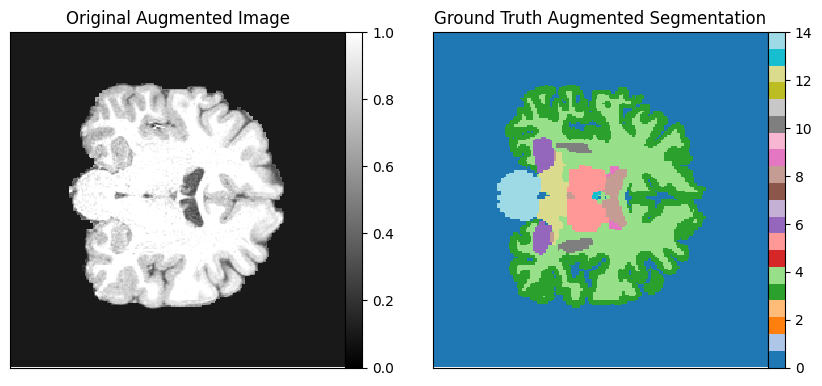

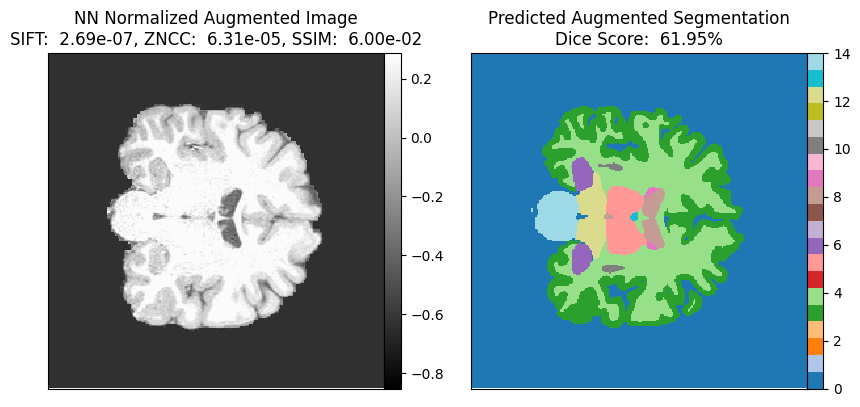



--------------------------------------------------




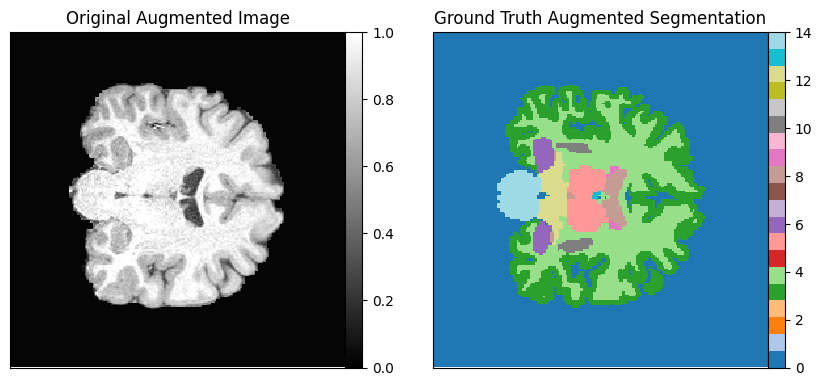

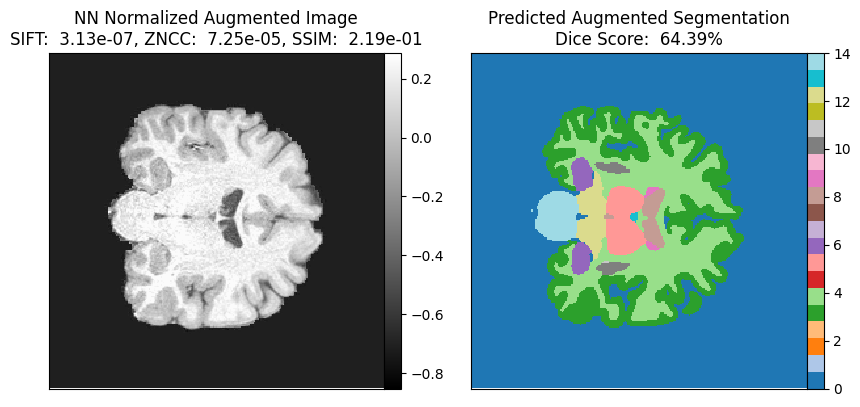



--------------------------------------------------




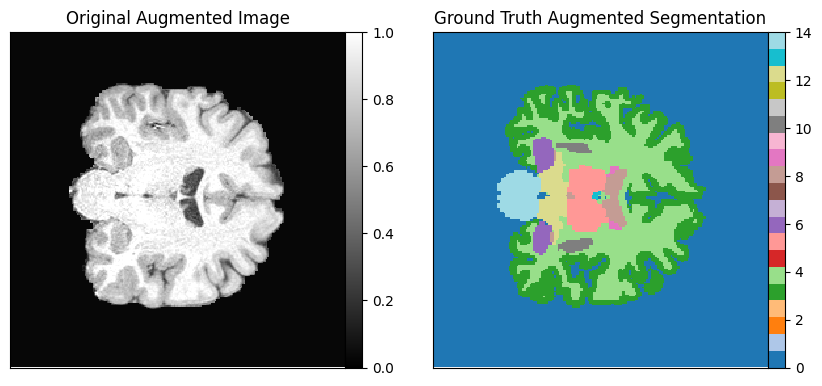

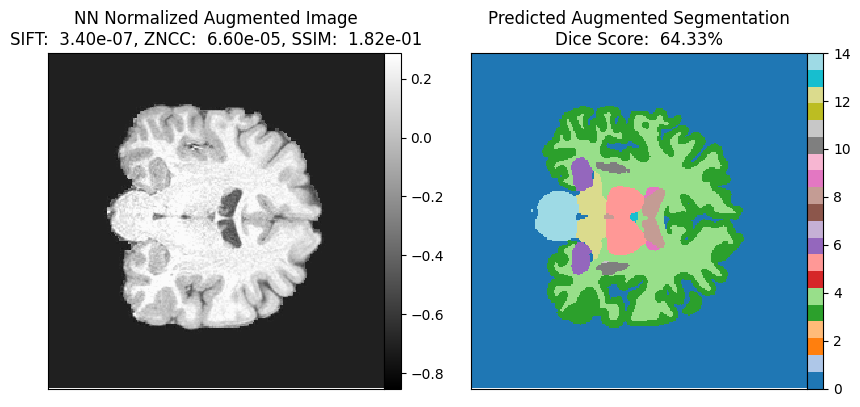



--------------------------------------------------




In [16]:
aug_args = {
    **aug_args_default,
    'tf_probs': {'brightness': 1.0}
}

ds.aug_params = aug_args

plot_augmentations(img_idx=128, num_examples=5, norm=norm, seg=seg, ds=ds)

In [17]:
aug_args

{'da_ratio': 0,
 'sigma': 20,
 'alpha': 1000,
 'trans_min': -10,
 'trans_max': 10,
 'rot_min': -10,
 'rot_max': 10,
 'scale_min': 0.9,
 'scale_max': 1.1,
 'gamma_min': 0.5,
 'gamma_max': 2.0,
 'brightness_min': 0.0,
 'brightness_max': 0.1,
 'noise_mean': 0.0,
 'noise_std': 0.1,
 'tf_probs': {'brightness': 1.0}}

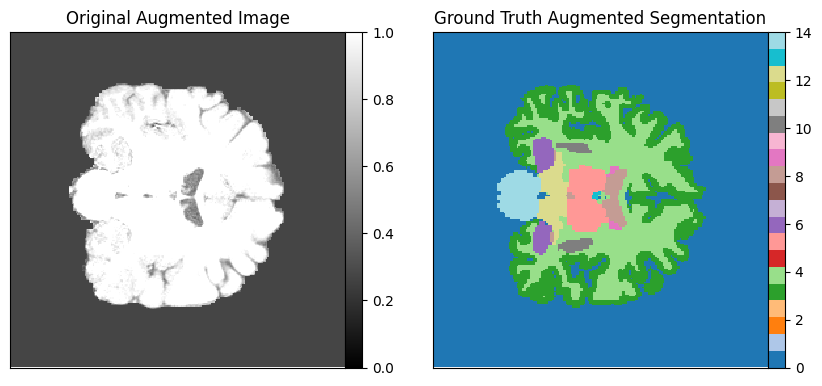

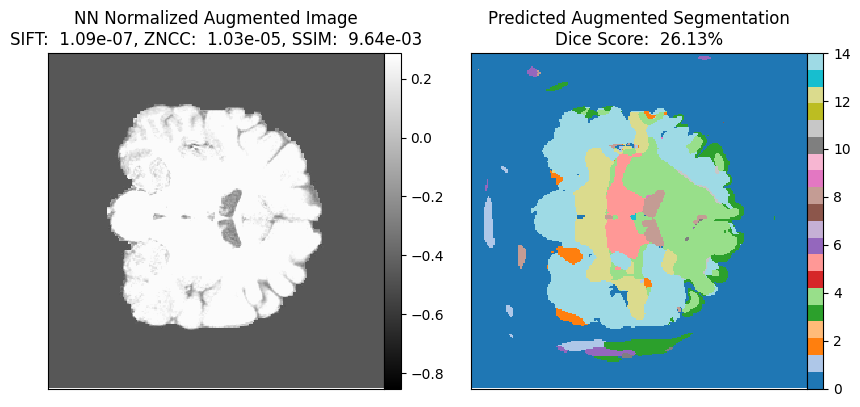



--------------------------------------------------




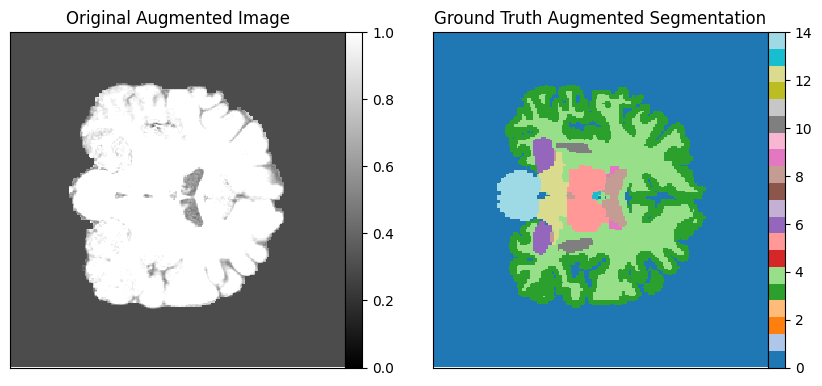

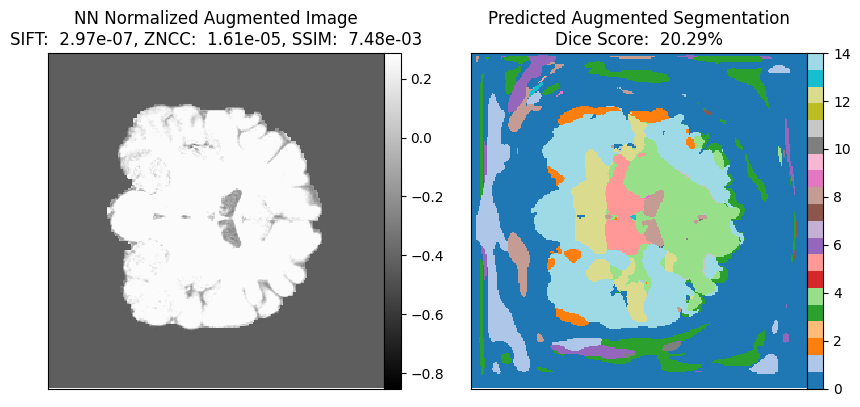



--------------------------------------------------




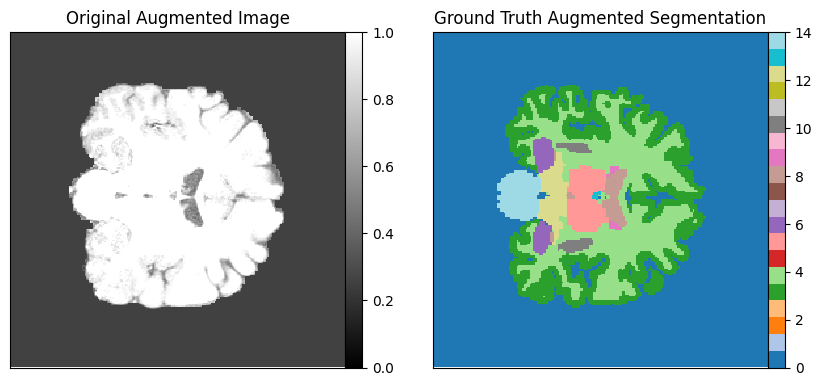

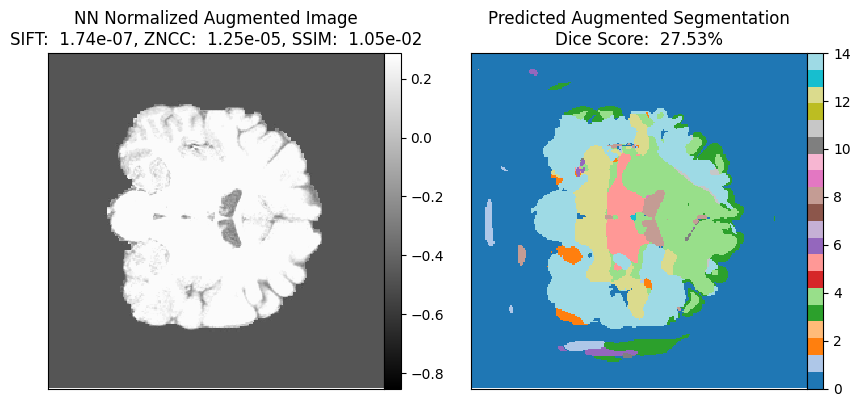



--------------------------------------------------




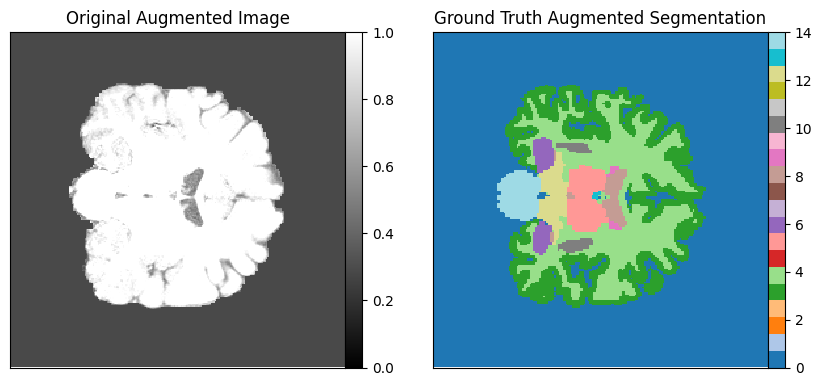

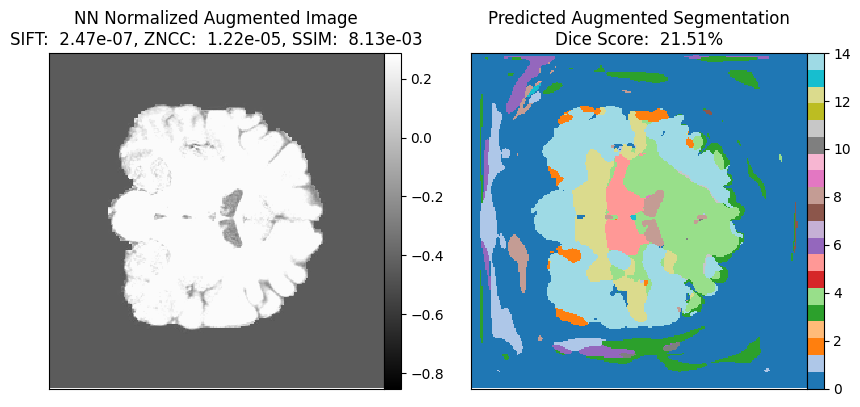



--------------------------------------------------




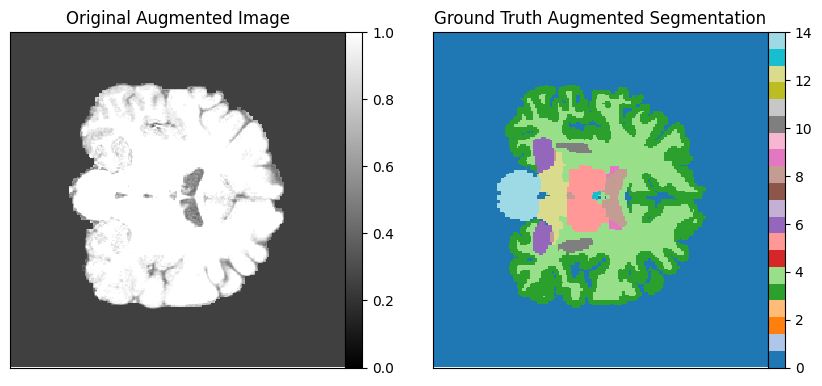

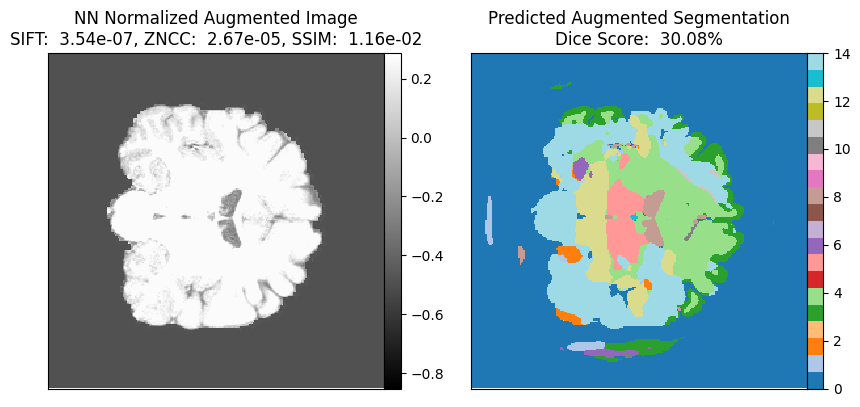



--------------------------------------------------




In [18]:
aug_args = {
    **aug_args_default,
    'tf_probs': {'brightness': 1.0}
}
aug_args['brightness_min'] = 0.25
aug_args['brightness_max'] = 0.3
ds.aug_params = aug_args

plot_augmentations(img_idx=128, num_examples=5, norm=norm, seg=seg, ds=ds)

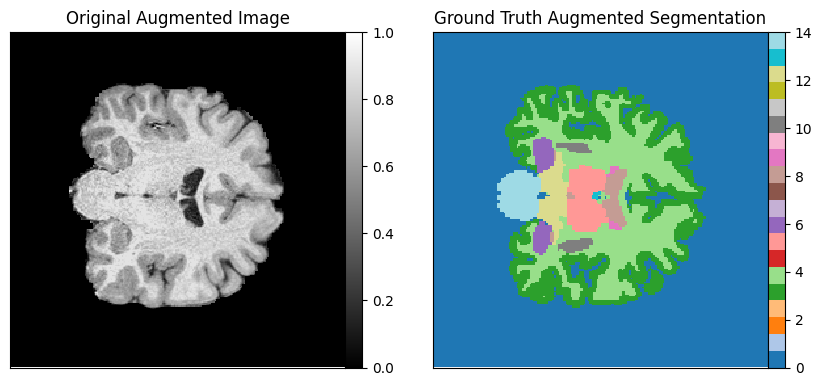

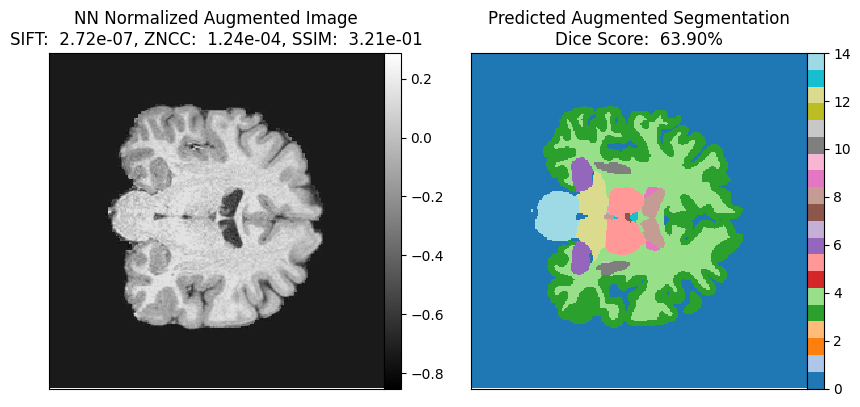



--------------------------------------------------




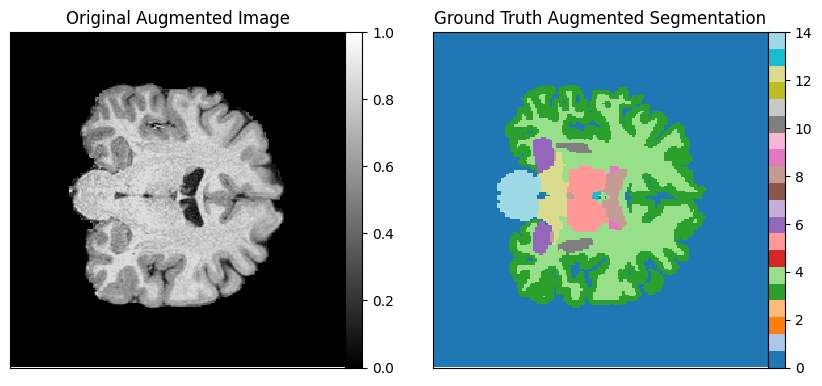

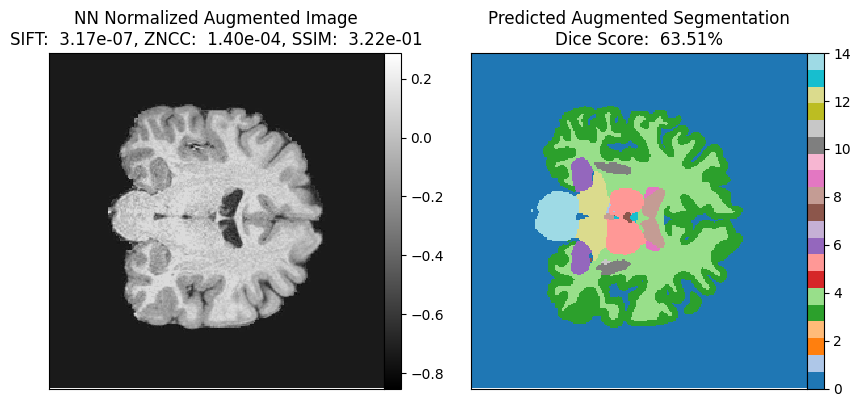



--------------------------------------------------




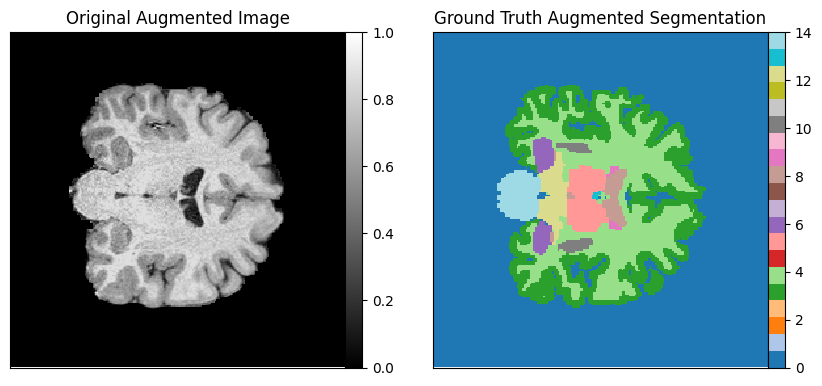

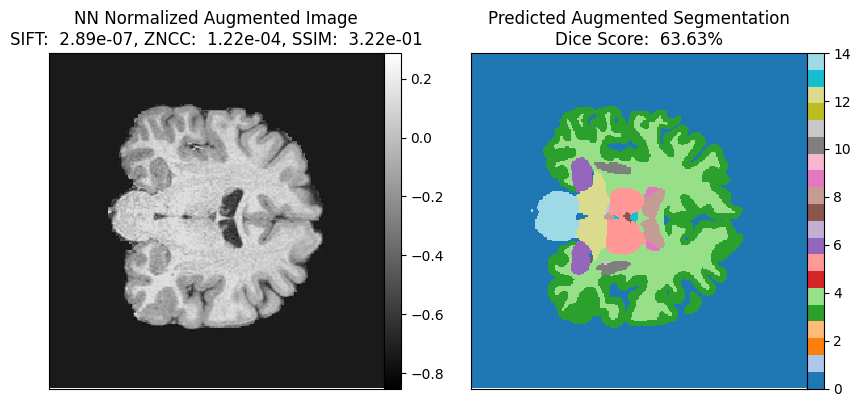



--------------------------------------------------




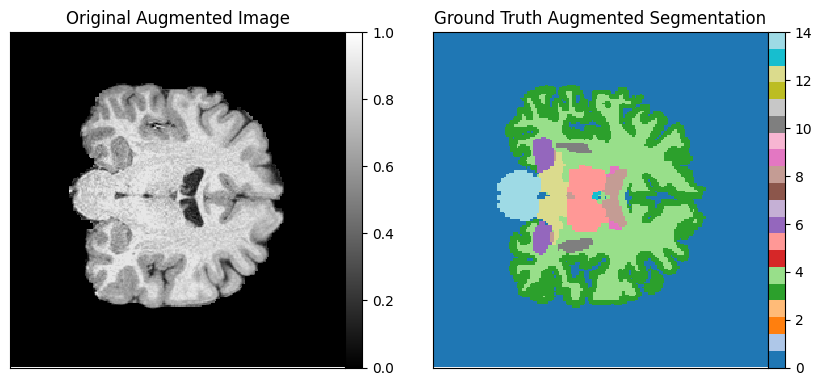

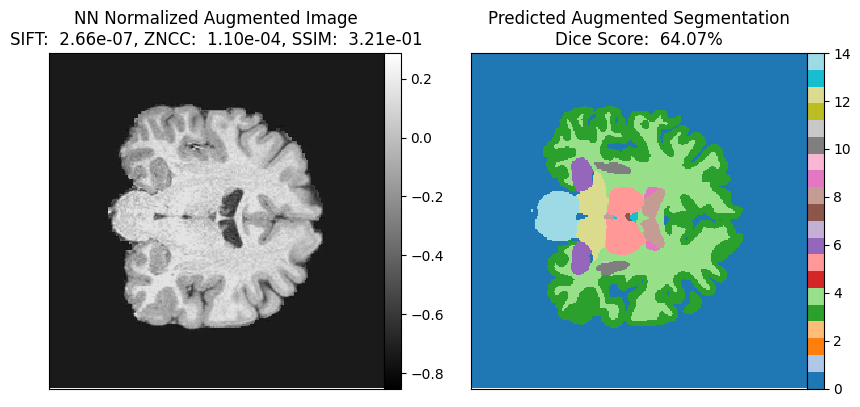



--------------------------------------------------




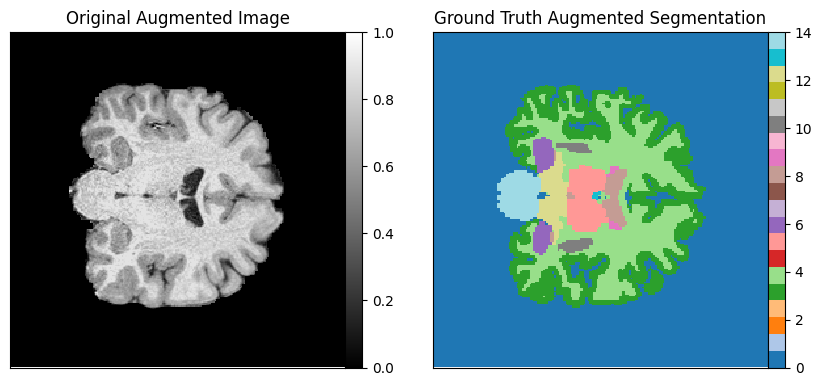

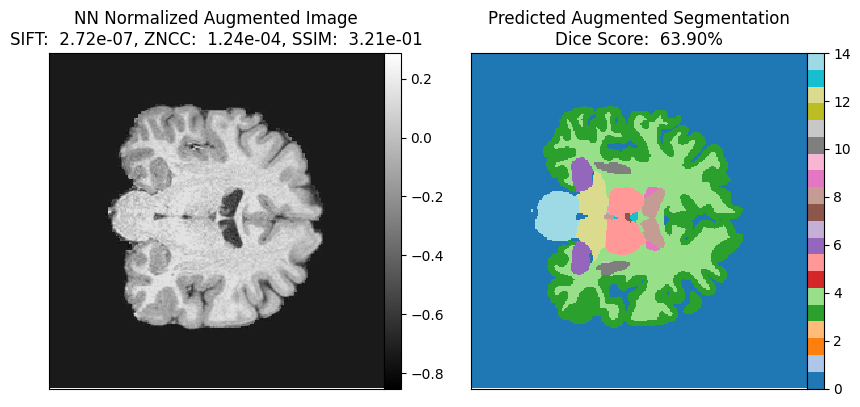



--------------------------------------------------




In [19]:
aug_args = {
    **aug_args_default,
    'tf_probs': {'brightness': 1.0}
}
aug_args['brightness_min'] = -0.2
aug_args['brightness_max'] = -0.1
ds.aug_params = aug_args

plot_augmentations(img_idx=128, num_examples=5, norm=norm, seg=seg, ds=ds)

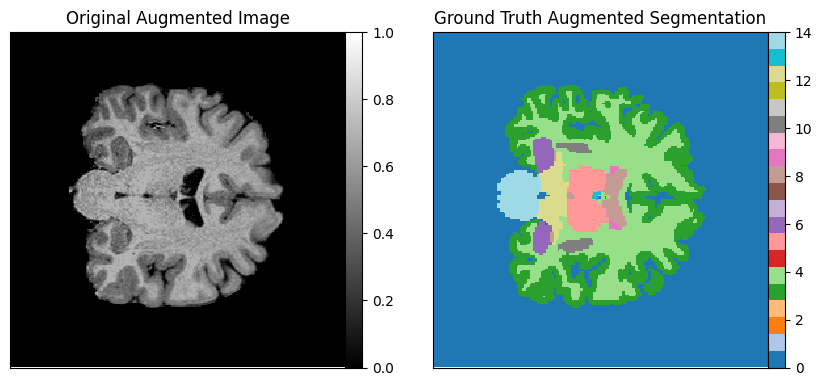

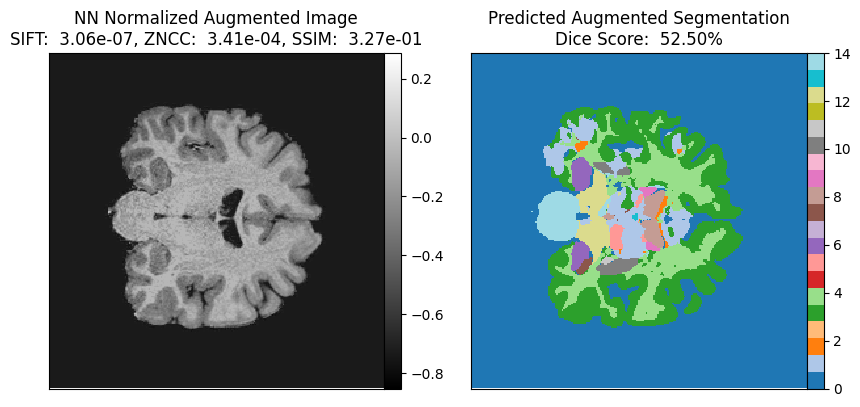



--------------------------------------------------




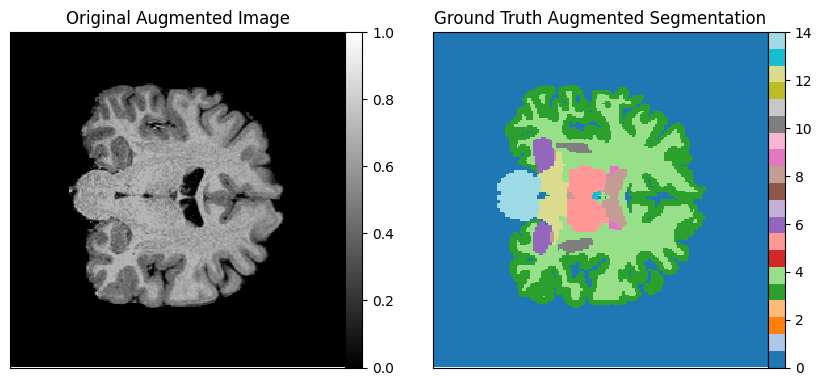

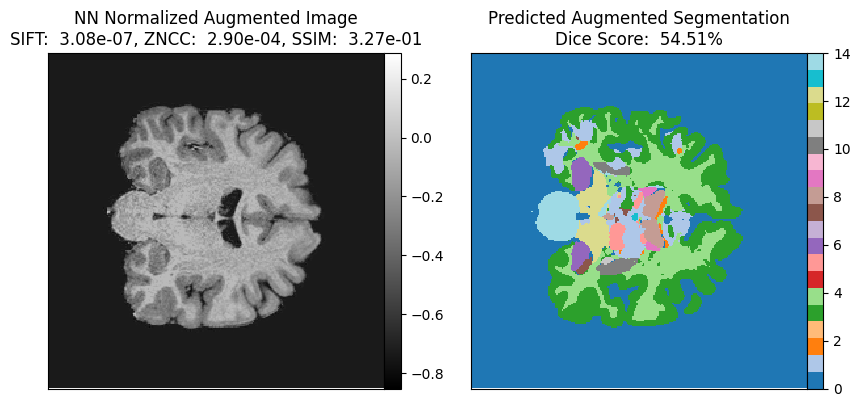



--------------------------------------------------




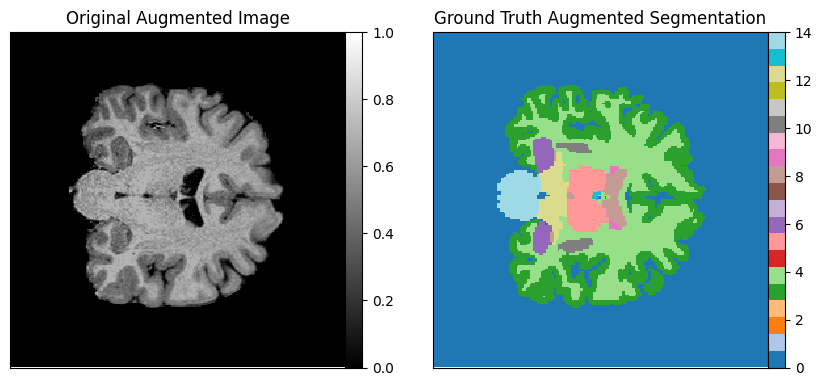

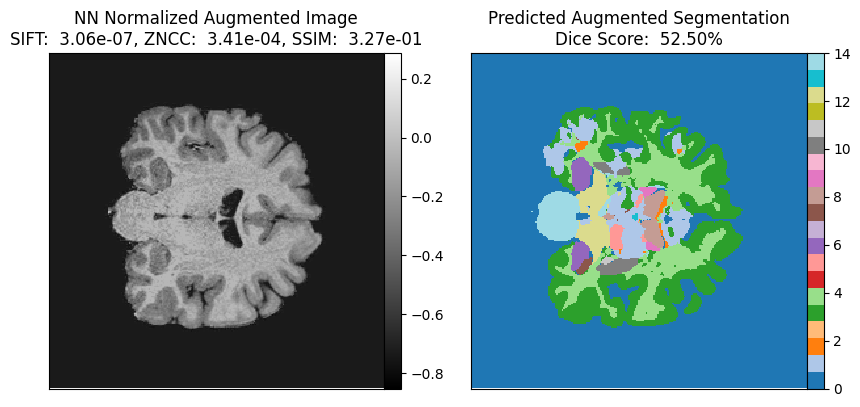



--------------------------------------------------




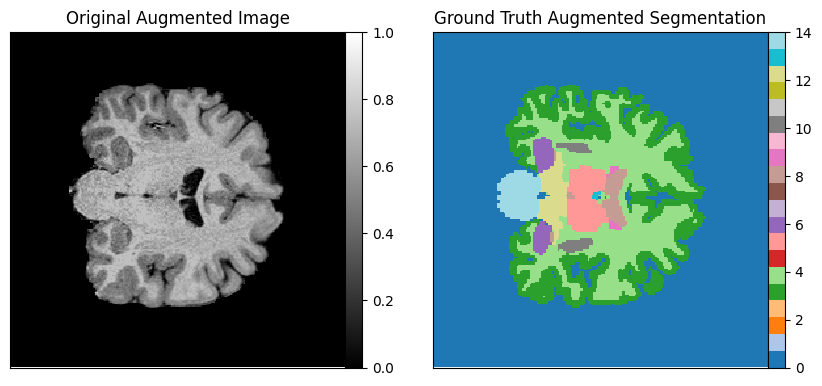

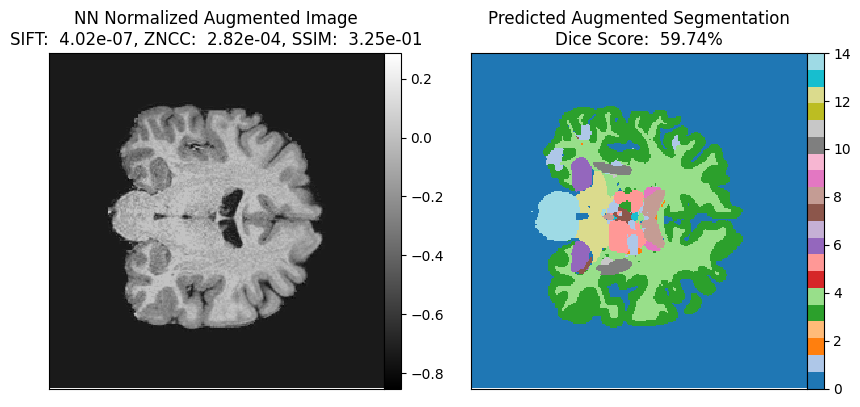



--------------------------------------------------




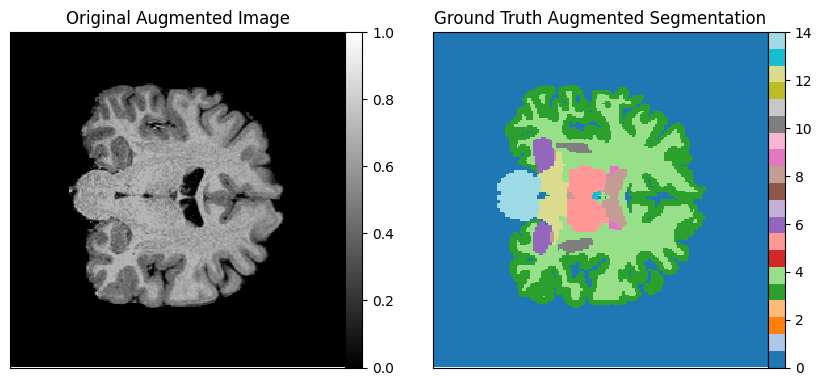

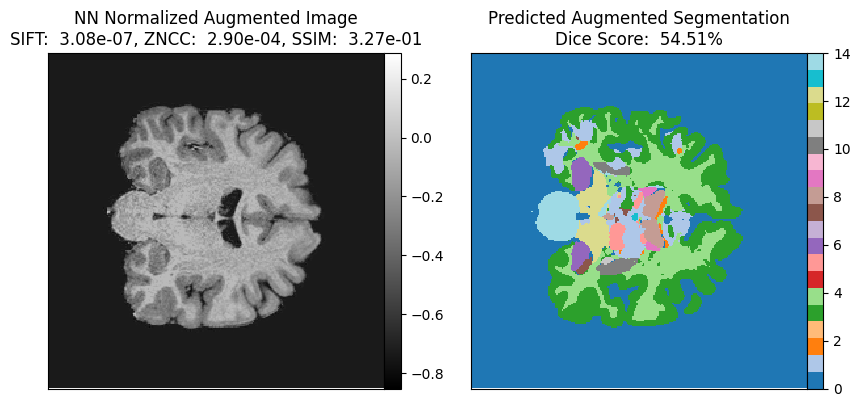



--------------------------------------------------




In [21]:
aug_args = {
    **aug_args_default,
    'tf_probs': {'brightness': 1.0}
}
aug_args['brightness_min'] = -0.3
aug_args['brightness_max'] = -0.25
ds.aug_params = aug_args

plot_augmentations(img_idx=128, num_examples=5, norm=norm, seg=seg, ds=ds)


### Noise